# Self Detection Two-Stage Compensation 가이드

Capacitive proximity sensors의 self-induced baseline을 제거하기 위한 **두 단계 보상 전략**입니다.

## Self Detection이란?

로봇 자체 움직임으로 인한 센서 기울기 변화:
- 로봇 팔의 자신의 움직임이 센서에 영향을 미치는 현상
- 관절 각도와 센서값 간의 관계를 학습

## 두 단계 보상 전략

**Stage 1: 정적 오프셋 모델 (36-73% 분산 감소)**
- 입력: 관절 각도(q만 사용)
- 출력: 정적 기울기 오프셋
- 목적: 자세 의존적 기울기 제거
- 방정식: `b̂(t) = f(q(t))`

**Stage 2: 단기 메모리 모델 (잔차 hysteresis 제거)**
- 입력: 잔차 단기 이력 (K=5 샘플)
- 출력: 메모리 효과 보정
- 목적: 유전체 완화 및 hysteresis 제거
- 방정식: `r̂(t) = g(r(t-1), ..., r(t-K))`

최종 보상: `y_corr(t) = raw(t) - b̂(t) - r̂(t)`

## 1단계: 필요한 패키지 임포트

In [21]:
import numpy as np
import torch
from pathlib import Path

from self_detection_mlp import (
    DataLoader, JointVelocityComputer, OutputNormalizer,
    SelfDetectionMLP, Trainer, Evaluator
)
from self_detection_mlp.preprocessing import prepare_training_data
from self_detection_mlp.utils import set_seed, get_device, sensor_compensation

print("모든 패키지가 정상적으로 임포트되었습니다!")

모든 패키지가 정상적으로 임포트되었습니다!


## 2단계: 환경 설정

In [22]:
# 설정
CONFIG = {
    "data_file": "C:\\Users\\SongYoungBin\\Desktop\\self_detection_mlp\\Data.txt",  # 여기에 TXT 파일 경로를 입력하세요 (쉼표로 구분된 형식)
    "train_ratio": 0.7,  # 훈련 데이터 비율
    "epochs": 200,  # 에포크 수
    "batch_size": 32,  # 배치 크기
    "learning_rate": 0.001,  # 학습률
    "hidden_dim": 32,  # 숨겨진 레이어 차원
    "seed": 42,  # 랜덤 시드
}

# 재현성을 위해 시드 설정
set_seed(CONFIG["seed"])
device = get_device()

print(f"사용 중인 디바이스: {device}")
print(f"\n설정:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

사용 중인 디바이스: cpu

설정:
  data_file: C:\Users\SongYoungBin\Desktop\self_detection_mlp\Data.txt
  train_ratio: 0.7
  epochs: 200
  batch_size: 32
  learning_rate: 0.001
  hidden_dim: 32
  seed: 42


## 3단계: 데이터 로딩

In [23]:
# TXT 파일에서 데이터 로드 및 필터링
print("\n[3단계] 데이터 로딩 및 필터링...")
print(f"파일 경로: {CONFIG['data_file']}")

# TXT 파일 읽기 (헤더 없음, # 주석 제외)
import pandas as pd

# 컬럼명 정의 (README의 데이터 포맷 참고)
column_names = ['timestamp', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 
                'prox1', 'prox2', 'prox3', 'prox4',
                'raw1', 'raw2', 'raw3', 'raw4',
                'tof1', 'tof2', 'tof3', 'tof4']

data = pd.read_csv(CONFIG["data_file"], 
                   comment='#',  # # 로 시작하는 행 제외
                   sep=',',      # 쉼표로 구분
                   skipinitialspace=True,  # 공백 제거
                   names=column_names)  # 컬럼명 직접 지정

print(f"\n  원본 데이터 형태: {data.shape}")
print(f"  컬럼명: {list(data.columns)}")

# 필요한 컬럼만 추출
# 사용할 것: timestamp, j2~j6 (5개 관절), raw1~raw4 (센서값)
# 사용 안 할 것: j1, prox1~4 (용량 센서), tof1~4 (거리 센서)

data_filtered = data[['timestamp', 'j2', 'j3', 'j4', 'j5', 'j6', 
                      'raw1', 'raw2', 'raw3', 'raw4']].copy()

print(f"\n  ✓ 필터링 후 데이터 형태: {data_filtered.shape}")
print(f"  ✓ 사용하는 컬럼: {list(data_filtered.columns)}")
print(f"\n  [데이터 샘플 (첫 5행)]")
print(data_filtered.head())

# 넘파이 배열로 변환
joint_angles = data_filtered[['j2', 'j3', 'j4', 'j5', 'j6']].values.astype(float)  # (N, 5)
raw_sensors = data_filtered[['raw1', 'raw2', 'raw3', 'raw4']].values.astype(float)  # (N, 4)
timestamps = pd.to_datetime(data_filtered['timestamp'], format='%Y-%m-%d %H%M%S.%f').values

# 타임스탬프에서 시간 간격 계산 (초 단위)
time_deltas = np.diff(timestamps) / np.timedelta64(1, 's')

print(f"\n  ✓ 관절 각도 형태: {joint_angles.shape} (j2~j6)")
print(f"  ✓ 센서값 형태: {raw_sensors.shape} (raw1~raw4)")
print(f"  ✓ 타임스탬프 간격: {time_deltas.shape}")

print(f"\n  [제거된 데이터: j1, 용량센서(prox1-4), TOF센서(tof1-4)]")


[3단계] 데이터 로딩 및 필터링...
파일 경로: C:\Users\SongYoungBin\Desktop\self_detection_mlp\Data.txt

  원본 데이터 형태: (6460, 19)
  컬럼명: ['timestamp', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'prox1', 'prox2', 'prox3', 'prox4', 'raw1', 'raw2', 'raw3', 'raw4', 'tof1', 'tof2', 'tof3', 'tof4']

  ✓ 필터링 후 데이터 형태: (6460, 10)
  ✓ 사용하는 컬럼: ['timestamp', 'j2', 'j3', 'j4', 'j5', 'j6', 'raw1', 'raw2', 'raw3', 'raw4']

  [데이터 샘플 (첫 5행)]
               timestamp      j2        j3       j4       j5     j6  \
0  2026-01-16 163828.867  1.5698 -108.4549  16.8848 -89.9961  1.242   
1  2026-01-16 163828.877  1.5698 -108.4549  16.8848 -89.9961  1.242   
2  2026-01-16 163828.887  1.5698 -108.4549  16.8848 -89.9961  1.242   
3  2026-01-16 163828.898  1.5698 -108.4549  16.8848 -89.9961  1.242   
4  2026-01-16 163828.908  1.5698 -108.4549  16.8848 -89.9961  1.242   

         raw1        raw2        raw3        raw4  
0  39999676.0  39999536.0  39998832.0  39999352.0  
1  39999676.0  39999536.0  39998832.0  39999352.0  
2  399996

## 4단계: 훈련 데이터 준비

In [25]:
# 훈련 데이터 준비 (Stage 1: 관절 각도만 사용)
print("\n[4단계] 훈련 데이터 준비 중...")

# 중앙 차분으로 인해 첫 번째와 마지막 샘플이 제외되므로, 각도와 센서값도 맞춰야 함
angles_trimmed = joint_angles[1:-1]  # (N-2, 5)
sensors_trimmed = raw_sensors[1:-1]  # (N-2, 4)

print(f"  원본 데이터: {joint_angles.shape}")
print(f"  트림 후: {angles_trimmed.shape}")
print(f"  센서값 정렬: {sensors_trimmed.shape}")

# ========================================================
# Stage 1: 관절 각도(q)만 사용하여 정적 오프셋 학습
# ========================================================
X = angles_trimmed  # (N-2, 5): 관절 각도만! (속도는 사용하지 않음)
y = sensors_trimmed  # (N-2, 4): 센서값

print(f"\n  입력 특성 (X) 형태: {X.shape}")
print(f"    - Stage 1 입력: 관절 각도 5개 (q2, q3, q4, q5, q6만 사용)")
print(f"  출력 (y) 형태: {y.shape}")
print(f"    - 예측 대상: 센서값 4개")

# 시간 기반 분할 (시간순으로 훈련/검증 분할)
split_idx = int(len(X) * CONFIG["train_ratio"])
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"\n  훈련 세트: X={X_train.shape}, y={y_train.shape}")
print(f"  검증 세트: X={X_val.shape}, y={y_val.shape}")

# 입력 특성(X) 정규화 (훈련 세트 기준)
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_std[X_std == 0] = 1  # 표준편차가 0인 경우 방지

X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std

print(f"\n  입력 특성(X) 정규화 적용:")
print(f"    평균: {X_mean}")
print(f"    표준편차: {X_std}")

# 센서값(y) 정규화 전에 원본 데이터 보관 (역정규화를 위해)
y_val_original = y_val.copy()
y_train_original = y_train.copy()

# 센서값(y) 정규화 (훈련 세트의 통계로 정규화)
# 수동으로 정규화 (평균과 표준편차 기반)
y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)
y_train_std[y_train_std == 0] = 1  # 표준편차가 0인 경우 방지

y_train_norm = (y_train - y_train_mean) / y_train_std
y_val_norm = (y_val - y_train_mean) / y_train_std

print(f"\n  센서값(y) 정규화 적용:")
print(f"    평균: {y_train_mean}")
print(f"    표준편차: {y_train_std}")

# 정규화된 데이터를 훈련에 사용
y_train = y_train_norm
y_val = y_val_norm

# OutputNormalizer는 나중에 역정규화(denormalization)를 위해 사용
from self_detection_mlp.preprocessing import OutputNormalizer
normalizer = OutputNormalizer()
normalizer.means = y_train_mean
normalizer.stds = y_train_std

print(f"\n  ✓ 모든 데이터 정규화 완료")



[4단계] 훈련 데이터 준비 중...
  원본 데이터: (6460, 5)
  트림 후: (6458, 5)
  센서값 정렬: (6458, 4)

  입력 특성 (X) 형태: (6458, 5)
    - Stage 1 입력: 관절 각도 5개 (q2, q3, q4, q5, q6만 사용)
  출력 (y) 형태: (6458, 4)
    - 예측 대상: 센서값 4개

  훈련 세트: X=(4520, 5), y=(4520, 4)
  검증 세트: X=(1938, 5), y=(1938, 4)

  입력 특성(X) 정규화 적용:
    평균: [ -12.82116684 -111.70837046   52.41905699  -91.33020305    2.64049816]
    표준편차: [18.86035036 21.58381773 12.86073629  0.61551411  3.0047357 ]

  센서값(y) 정규화 적용:
    평균: [39998819.88584071 39997491.79026549 39997405.22654867 39999338.05221239]
    표준편차: [1921.19440662 2497.35166953 5059.83262272  593.83530159]

  ✓ 모든 데이터 정규화 완료


## 5단계: 모델 생성

In [26]:
# MLP 모델 생성 (Stage 1: 정적 오프셋)
print("\n[5단계] Stage 1 MLP 모델 생성 중...")
print("\n" + "="*70)
print("Stage 1: 정적 오프셋 모델 (Static Baseline Offset Model)")
print("="*70)
print(f"  입력: 관절 각도만 (5개) → 출력: 센서 오프셋 (4개)")
print(f"  목적: 자세 의존적 기울기 제거 (36-73% 분산 감소)")
print(f"  방정식: b̂(t) = f(q(t))")
print(f"  모델 구조: 5입력 → 32숨겨진 → 4출력")

model = SelfDetectionMLP(
    input_dim=5,       # 관절 각도만 5개 (q2, q3, q4, q5, q6)
    output_dim=4,      # 4개 센서값 (raw1~raw4)
    hidden_dim=CONFIG["hidden_dim"],  # 32
    dropout=0.1        # Dropout: 과적합 방지
)

# GPU로 이동
model = model.to(device)

print(f"\n모델 구조:")
print(model)
print(f"\n모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
print("="*70)



[5단계] Stage 1 MLP 모델 생성 중...

Stage 1: 정적 오프셋 모델 (Static Baseline Offset Model)
  입력: 관절 각도만 (5개) → 출력: 센서 오프셋 (4개)
  목적: 자세 의존적 기울기 제거 (36-73% 분산 감소)
  방정식: b̂(t) = f(q(t))
  모델 구조: 5입력 → 32숨겨진 → 4출력

모델 구조:
SelfDetectionMLP(
  (stage1): Stage1StaticOffsetMLP(
    (net): Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=32, out_features=4, bias=True)
    )
  )
)

모델 파라미터 수: 1,380


## 6단계: Stage 1 모델 훈련 (정적 오프셋)

관절 각도(q)만을 입력으로 정적 기울기 오프셋 **b̂(q)**을 학습합니다.
- 로봇의 자세만으로 센서의 자체 유도 기울기를 예측
- 이를 제거하면 36~73%의 분산 감소


In [27]:
# Stage 1 모델 훈련
print("\n[6단계] Stage 1 모델 훈련 중...")
print("="*70)
trainer = Trainer(model, device=device)

history = trainer.train(
    X_train, y_train, X_val, y_val,
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    learning_rate=CONFIG["learning_rate"],
    patience=30,
    verbose=True
)

print("\n" + "="*70)
print(f"✓ Stage 1 훈련 완료!")
print(f"  최종 훈련 손실: {history['train_loss'][-1]:.6f}")
print(f"  최종 검증 손실: {history['val_loss'][-1]:.6f}")
print("="*70)



[6단계] Stage 1 모델 훈련 중...
Epoch 10/200 - Train Loss: 0.349379, Val Loss: 0.427558
Epoch 20/200 - Train Loss: 0.337297, Val Loss: 0.411052
Epoch 30/200 - Train Loss: 0.332864, Val Loss: 0.421211
Epoch 40/200 - Train Loss: 0.329241, Val Loss: 0.391460
Epoch 50/200 - Train Loss: 0.330729, Val Loss: 0.404006
Epoch 60/200 - Train Loss: 0.322835, Val Loss: 0.376035
Epoch 70/200 - Train Loss: 0.319835, Val Loss: 0.404869
Epoch 80/200 - Train Loss: 0.318778, Val Loss: 0.380068
Epoch 90/200 - Train Loss: 0.314103, Val Loss: 0.397584
Epoch 100/200 - Train Loss: 0.317278, Val Loss: 0.382946
Epoch 110/200 - Train Loss: 0.310991, Val Loss: 0.378408
Epoch 120/200 - Train Loss: 0.307486, Val Loss: 0.393932
Epoch 130/200 - Train Loss: 0.313785, Val Loss: 0.377923
Epoch 140/200 - Train Loss: 0.310166, Val Loss: 0.398288
Epoch 150/200 - Train Loss: 0.311084, Val Loss: 0.383301
Early stopping at epoch 154

✓ Stage 1 훈련 완료!
  최종 훈련 손실: 0.312407
  최종 검증 손실: 0.399598


## 7단계: Stage 1 훈련 곡선 시각화

C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\3962870542.py:29: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\3962870542.py:29: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\3962870542.py:29: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\3962870542.py:29: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\SongYoungBin\Desktop\self_detection_mlp\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SongYoungBin\Desktop\self_detection_m

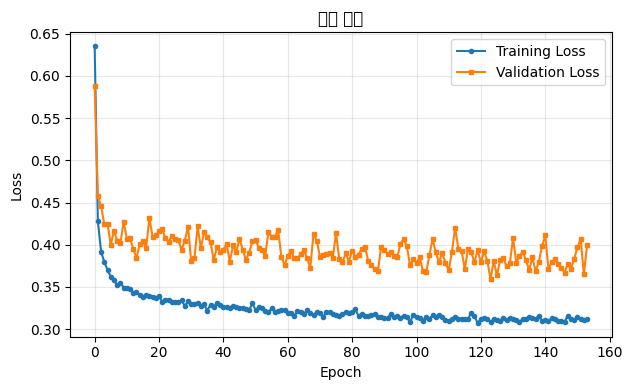

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 손실 곡선
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss', marker='o', markersize=3)
plt.plot(history['val_loss'], label='Validation Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('모델 손실')
plt.legend()
plt.grid(True, alpha=0.3)

# 평가 메트릭
if 'val_metrics' in history:
    plt.subplot(1, 2, 2)
    metrics = history['val_metrics']
    if 'std_reduction' in metrics:
        plt.plot(metrics['std_reduction'], label='Std Reduction', marker='o')
    if 'ptp_reduction' in metrics:
        plt.plot(metrics['ptp_reduction'], label='PTP Reduction', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Reduction Rate')
    plt.title('평가 메트릭')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8단계: Stage 1 평가 및 잔차 계산

In [29]:
# Stage 1 평가: 정적 오프셋 제거 후 잔차 계산
print("\n[8단계] Stage 1 평가 및 잔차 계산...")
model.eval()

# Stage 1 예측 (정적 오프셋)
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val).float().to(device)
    stage1_pred_norm = model(X_val_tensor)
    stage1_pred = stage1_pred_norm.cpu().numpy()

# 정규화된 예측값을 원래 스케일로 복원
stage1_offset_denorm = stage1_pred * normalizer.stds + normalizer.means
y_val_denorm = y_val_original  # 원본 데이터

# Stage 1 보상: 잔차 = 원본 - Stage1 오프셋
residual = y_val_denorm - stage1_offset_denorm

# Stage 1 성능 평가
mse_stage1 = np.mean((stage1_offset_denorm - y_val_denorm) ** 2)
rmse_stage1 = np.sqrt(mse_stage1)

print(f"\n[Stage 1 성능]")
print(f"  정적 오프셋 MSE: {mse_stage1:.6f}")
print(f"  정적 오프셋 RMSE: {rmse_stage1:.6f}")

# 잔차 통계
print(f"\n[잔차 통계]")
for i, name in enumerate(['raw1', 'raw2', 'raw3', 'raw4']):
    original_std = np.std(y_val_denorm[:, i])
    residual_std = np.std(residual[:, i])
    reduction = (original_std - residual_std) / original_std * 100
    print(f"  {name}: 표준편차 {original_std:.0f} → {residual_std:.0f} ({reduction:.1f}% 감소)")


[8단계] Stage 1 평가 및 잔차 계산...

[Stage 1 성능]
  정적 오프셋 MSE: 1156006.308083
  정적 오프셋 RMSE: 1075.177338

[잔차 통계]
  raw1: 표준편차 1975 → 849 (57.0% 감소)
  raw2: 표준편차 2580 → 1051 (59.3% 감소)
  raw3: 표준편차 3909 → 1301 (66.7% 감소)
  raw4: 표준편차 937 → 601 (35.9% 감소)


## 9단계: Stage 2 모델 - 잔차 단기 메모리 훈련

Stage 1으로 제거된 잔차의 hysteresis와 유전체 완화 효과를 제거합니다.
- 입력: 잔차 단기 이력 (K=5 샘플 = ~50ms)
- 출력: 메모리 효과 보정값
- 제약: 정규 신호만 사용, 관절각도나 원본신호 미사용

In [39]:
# Stage 2 모델: 잔차의 단기 메모리 모델
print("\n[9단계] Stage 2 메모리 모델 준비...")
print("="*70)
print("Stage 2: 잔차 단기 메모리 모델 (Residual Short-Memory Model)")
print("="*70)
print("  목적: Stage 1 후 남은 히스테리시스/유전체 완화 효과 제거")
print("  입력: 잔차의 단기 이력만 (관절각도/원본신호 미사용)")
print("  메모리: K=5 샘플 (~50ms)")
print("  방정식: r̂(t) = g([r(t-K),...,r(t-1)])")
print("="*70 + "\n")

import torch.nn as nn
from self_detection_mlp.model import Stage2ResidualMemoryMLP

MEMORY_WINDOW = 5  # K=5 샘플 (약 50ms)
STAGE2_HIDDEN_DIM = 12  # 작은 네트워크 (8-16 권장)

stage2_model = Stage2ResidualMemoryMLP(
    memory_window=MEMORY_WINDOW,
    output_dim=4,
    hidden_dim=STAGE2_HIDDEN_DIM,
    dropout=0.05
)
stage2_model = stage2_model.to(device)

print(f"Stage 2 모델 구조:")
print(stage2_model)
print(f"모델 파라미터 수: {sum(p.numel() for p in stage2_model.parameters()):,}")

# Stage 2 훈련 데이터 준비: 잔차의 단기 이력
print(f"\n[Stage 2 데이터 준비]")
print(f"  메모리 윈도우 크기: {MEMORY_WINDOW} 샘플 (~50ms)")

# 훈련 세트의 잔차 계산 (Stage 1 예측값 빼기)
with torch.no_grad():
    X_train_tensor = torch.from_numpy(X_train).float().to(device)
    stage1_train_pred_norm = model(X_train_tensor)
    stage1_train_pred = stage1_train_pred_norm.cpu().numpy()

stage1_train_offset = stage1_train_pred * normalizer.stds + normalizer.means
residual_train = y_train_original - stage1_train_offset

print(f"  훈련 잔차 형태: {residual_train.shape}")

# 메모리 윈도우 데이터 생성
def create_memory_sequences(residuals, memory_window):
    """시계열 잔차를 메모리 윈도우 시퀀스로 변환"""
    n_samples = len(residuals) - memory_window
    sequences = np.zeros((n_samples, memory_window, residuals.shape[1]))
    targets = np.zeros((n_samples, residuals.shape[1]))
    
    for i in range(n_samples):
        sequences[i] = residuals[i:i+memory_window]  # 과거 K개 샘플
        targets[i] = residuals[i+memory_window]       # 현재 샘플 (예측 타깃)
    
    return sequences, targets

residual_seqs_train, target_train = create_memory_sequences(residual_train, MEMORY_WINDOW)
residual_seqs_val, target_val = create_memory_sequences(residual, MEMORY_WINDOW)

print(f"  훈련 시퀀스: {residual_seqs_train.shape}")
print(f"  검증 시퀀스: {residual_seqs_val.shape}")

# 정규화 (훈련 세트 기준)
residual_train_mean = residual_seqs_train.mean(axis=(0, 1), keepdims=True)
residual_train_std = residual_seqs_train.std(axis=(0, 1), keepdims=True)
residual_train_std[residual_train_std == 0] = 1

residual_seqs_train_norm = (residual_seqs_train - residual_train_mean) / residual_train_std
residual_seqs_val_norm = (residual_seqs_val - residual_train_mean) / residual_train_std

target_train_mean = target_train.mean(axis=0)
target_train_std = target_train.std(axis=0)
target_train_std[target_train_std == 0] = 1

target_train_norm = (target_train - target_train_mean) / target_train_std
target_val_norm = (target_val - target_train_mean) / target_train_std

print(f"\n✓ Stage 2 데이터 준비 완료\n")

# Stage 2 훈련
print(f"[Stage 2 훈련 시작]")
stage2_optimizer = torch.optim.Adam(stage2_model.parameters(), lr=0.001)
stage2_criterion = nn.MSELoss()

stage2_history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in range(100):
    # 훈련
    stage2_model.train()
    train_loss = 0
    
    for i in range(0, len(residual_seqs_train_norm), 32):
        batch_seqs = torch.from_numpy(residual_seqs_train_norm[i:i+32]).float().to(device)
        batch_targets = torch.from_numpy(target_train_norm[i:i+32]).float().to(device)
        
        stage2_optimizer.zero_grad()
        pred = stage2_model(batch_seqs)
        loss = stage2_criterion(pred, batch_targets)
        loss.backward()
        stage2_optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= max(1, (len(residual_seqs_train_norm) // 32 + 1))
    stage2_history['train_loss'].append(train_loss)
    
    # 검증
    stage2_model.eval()
    with torch.no_grad():
        val_seqs = torch.from_numpy(residual_seqs_val_norm).float().to(device)
        val_targets = torch.from_numpy(target_val_norm).float().to(device)
        val_pred = stage2_model(val_seqs)
        val_loss = stage2_criterion(val_pred, val_targets).item()
    
    stage2_history['val_loss'].append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1:3d}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")
    
    if patience_counter >= patience:
        print(f"  Early stopping at epoch {epoch+1}")
        break

print(f"\n[Stage 2 훈련 완료]")
print(f"  최종 훈련 손실: {stage2_history['train_loss'][-1]:.6f}")
print(f"  최종 검증 손실: {stage2_history['val_loss'][-1]:.6f}")
print("="*70)



[9단계] Stage 2 메모리 모델 준비...
Stage 2: 잔차 단기 메모리 모델 (Residual Short-Memory Model)
  목적: Stage 1 후 남은 히스테리시스/유전체 완화 효과 제거
  입력: 잔차의 단기 이력만 (관절각도/원본신호 미사용)
  메모리: K=5 샘플 (~50ms)
  방정식: r̂(t) = g([r(t-K),...,r(t-1)])

Stage 2 모델 구조:
Stage2ResidualMemoryMLP(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=12, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=12, out_features=4, bias=True)
  )
)
모델 파라미터 수: 460

[Stage 2 데이터 준비]
  메모리 윈도우 크기: 5 샘플 (~50ms)
  훈련 잔차 형태: (4520, 4)
  훈련 시퀀스: (4515, 5, 4)
  검증 시퀀스: (1933, 5, 4)

✓ Stage 2 데이터 준비 완료

[Stage 2 훈련 시작]
  Epoch  10: train_loss=0.130703, val_loss=0.331072
  Epoch  20: train_loss=0.092260, val_loss=0.214728
  Epoch  30: train_loss=0.077946, val_loss=0.171813
  Epoch  40: train_loss=0.072151, val_loss=0.132887
  Epoch  50: train_loss=0.070999, val_loss=0.108494
  E

## 10단계: 두 단계 보상 결과 비교

In [32]:
# 두 단계 보상 결과 비교
print("\n[10단계] 두 단계 보상 결과 비교")
print("="*70)
print("최종 보상식: y_corr(t) = raw(t) - b̂(t) - r̂(t)")
print("="*70 + "\n")

# Stage 1 결과 (이미 계산됨)
print("[Stage 1만 사용한 보상]")
stage1_offset_denorm = stage1_pred * normalizer.stds + normalizer.means  # Stage 1 예측
residual_after_stage1 = y_val_denorm - stage1_offset_denorm  # Stage 1 후 잔차

print(f"  입력: 관절각도(q)만")
print(f"  출력: 정적 오프셋 b̂(t)")
print(f"  보상: y_s1(t) = raw(t) - b̂(t)\n")

# Stage 2 결과 계산
print("[Stage 1 + Stage 2 사용한 보상]")
stage2_model.eval()
with torch.no_grad():
    stage2_val_seqs = torch.from_numpy(residual_seqs_val_norm).float().to(device)
    stage2_pred_norm = stage2_model(stage2_val_seqs)
    stage2_pred = stage2_pred_norm.cpu().numpy()

# Stage 2 예측값 역정규화
stage2_correction = stage2_pred * target_train_std + target_train_mean

# 최종 보상 (Stage 1 + Stage 2)
# 주의: Stage 2는 메모리 윈도우로 인해 처음 K개 샘플이 없음
final_compensated = residual_after_stage1[MEMORY_WINDOW:] - stage2_correction

print(f"  입력: 잔차의 단기 이력 r(t-K),...,r(t-1)")
print(f"  출력: 메모리효과 보정 r̂(t)")
print(f"  보상: y_s2(t) = y_s1(t) - r̂(t) = raw(t) - b̂(t) - r̂(t)\n")

# 결과 비교표
print("["+"="*70+"]")
print(f"{'Sensor':<8} {'원본 Std':>12} {'Stage1 Std':>12} {'Stage2 Std':>12} {'개선율(%)':<10}")
print("["+"-"*70+"]")

improvements = []
for i, name in enumerate(['raw1', 'raw2', 'raw3', 'raw4']):
    original_std = np.std(y_val_denorm[:, i])
    stage1_std = np.std(residual_after_stage1[:, i])
    stage2_std = np.std(final_compensated[:, i]) if len(final_compensated) > 0 else stage1_std
    
    improvement = (original_std - stage2_std) / original_std * 100
    improvements.append(improvement)
    
    print(f"{name:<8} {original_std:>12.0f} {stage1_std:>12.0f} {stage2_std:>12.0f} {improvement:>9.1f}%")

print("["+"-"*70+"]")
avg_improvement = np.mean(improvements)
print(f"{'평균':<8} {'':>12} {'':>12} {'':>12} {avg_improvement:>9.1f}%")
print("="*70)

print(f"\n[신호 형태]")
print(f"  원본: {y_val_denorm.shape}")
print(f"  Stage 1 잔차: {residual_after_stage1.shape}")
print(f"  Stage 2 보상: {final_compensated.shape} (메모리 윈도우 K={MEMORY_WINDOW}로 인해 앞 {MEMORY_WINDOW}개 제외)")



[10단계] 두 단계 보상 결과 비교
최종 보상식: y_corr(t) = raw(t) - b̂(t) - r̂(t)

[Stage 1만 사용한 보상]
  입력: 관절각도(q)만
  출력: 정적 오프셋 b̂(t)
  보상: y_s1(t) = raw(t) - b̂(t)

[Stage 1 + Stage 2 사용한 보상]
  입력: 잔차의 단기 이력 r(t-K),...,r(t-1)
  출력: 메모리효과 보정 r̂(t)
  보상: y_s2(t) = y_s1(t) - r̂(t) = raw(t) - b̂(t) - r̂(t)

[======================================================================]
Sensor         원본 Std   Stage1 Std   Stage2 Std 개선율(%)    
[----------------------------------------------------------------------]
raw1             1975          849          233      88.2%
raw2             2580         1051          212      91.8%
raw3             3909         1301          161      95.9%
raw4              937          601           85      90.9%
[----------------------------------------------------------------------]
평균                                                   91.7%

[신호 형태]
  원본: (1938, 4)
  Stage 1 잔차: (1938, 4)
  Stage 2 보상: (1933, 4) (메모리 윈도우 K=5로 인해 앞 5개 제외)


## 11단계: Stage 1 검증 성능 평가


In [33]:
# Stage 1 검증 세트에서 모델 평가
print("\n[평가] Stage 1 검증 성능")
model.eval()

# 정규화된 예측값 계산
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val).float().to(device)
    predictions_norm_tensor = model(X_val_tensor)
    predictions_norm = predictions_norm_tensor.cpu().numpy()

# 정규화된 예측값을 원래 스케일로 복원
predictions_denorm = predictions_norm * normalizer.stds + normalizer.means
stage1_pred = predictions_denorm  # Stage 1 예측 (이전 섹션과 동일)

# 손실 계산
mse = np.mean((predictions_denorm - y_val_denorm) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions_denorm - y_val_denorm))

print(f"\n  검증 세트 성능 (Stage 1):")
print(f"    MSE: {mse:.6f}")
print(f"    RMSE: {rmse:.6f}")
print(f"    MAE: {mae:.6f}")



[평가] Stage 1 검증 성능

  검증 세트 성능 (Stage 1):
    MSE: 1156006.308083
    RMSE: 1075.177338
    MAE: 707.645766


## 12단계: Stage 1 보상 효과 시각화


In [34]:
# Stage 1 보상 효과 분석
print("\n[12단계] Stage 1 보상 효과 분석")
print("="*70)

# 원본 vs 보상된 신호 비교
original_signals = y_val_denorm
stage1_compensated = original_signals - stage1_offset_denorm

print("\n[각 센서별 개선율]")
for i, name in enumerate(['raw1', 'raw2', 'raw3', 'raw4']):
    original_std = np.std(original_signals[:, i])
    compensated_std = np.std(stage1_compensated[:, i])
    improvement = (original_std - compensated_std) / original_std * 100
    print(f"  {name}: {original_std:.0f} → {compensated_std:.0f} ({improvement:.1f}% 개선)")

print("="*70)



[12단계] Stage 1 보상 효과 분석

[각 센서별 개선율]
  raw1: 1975 → 849 (57.0% 개선)
  raw2: 2580 → 1051 (59.3% 개선)
  raw3: 3909 → 1301 (66.7% 개선)
  raw4: 937 → 601 (35.9% 개선)


## 13단계: Stage 1 & Stage 2 모델 저장 및 로드


In [35]:
# 모델 저장
import os
os.makedirs("models", exist_ok=True)

print("\n[13단계] 모델 저장 중...")
print("="*70)

# Stage 1 모델 저장
stage1_path = "models/stage1_static_offset_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'input_dim': 5,
        'output_dim': 4,
        'hidden_dim': CONFIG['hidden_dim'],
        'stage': 1
    }
}, stage1_path)
print(f"✓ Stage 1 모델 저장: {stage1_path}")

# Stage 2 모델 저장
stage2_path = "models/stage2_residual_memory_model.pth"
torch.save({
    'model_state_dict': stage2_model.state_dict(),
    'config': {
        'memory_window': MEMORY_WINDOW,
        'output_dim': 4,
        'hidden_dim': STAGE2_HIDDEN_DIM,
        'stage': 2
    }
}, stage2_path)
print(f"✓ Stage 2 모델 저장: {stage2_path}")

# 정규화 통계 저장
norm_data = {
    'stage1_means': torch.from_numpy(normalizer.means),
    'stage1_stds': torch.from_numpy(normalizer.stds),
    'stage2_target_means': torch.from_numpy(target_train_mean),
    'stage2_target_stds': torch.from_numpy(target_train_std),
}
norm_path = "models/normalization_params.pt"
torch.save(norm_data, norm_path)
print(f"✓ 정규화 통계 저장: {norm_path}")

print("\n[모델 로드 예제]")
print("-"*70)

# Stage 1 모델 로드 예제
loaded_stage1 = SelfDetectionMLP(input_dim=5, output_dim=4, hidden_dim=32)
checkpoint1 = torch.load(stage1_path)
loaded_stage1.load_state_dict(checkpoint1['model_state_dict'])
print(f"✓ Stage 1 모델 로드됨 (입력: 5, 출력: 4)")

# Stage 2 모델 로드 예제
from self_detection_mlp.model import Stage2ResidualMemoryMLP
loaded_stage2 = Stage2ResidualMemoryMLP(memory_window=MEMORY_WINDOW, output_dim=4, hidden_dim=STAGE2_HIDDEN_DIM)
checkpoint2 = torch.load(stage2_path)
loaded_stage2.load_state_dict(checkpoint2['model_state_dict'])
print(f"✓ Stage 2 모델 로드됨 (메모리 윈도우: {MEMORY_WINDOW}, 출력: 4)")

# 정규화 통계 로드 예제
norm_loaded = torch.load(norm_path)
print(f"✓ 정규화 통계 로드됨 (Stage 1 & 2)")

print("="*70)



[13단계] 모델 저장 중...
✓ Stage 1 모델 저장: models/stage1_static_offset_model.pth
✓ Stage 2 모델 저장: models/stage2_residual_memory_model.pth
✓ 정규화 통계 저장: models/normalization_params.pt

[모델 로드 예제]
----------------------------------------------------------------------
✓ Stage 1 모델 로드됨 (입력: 5, 출력: 4)
✓ Stage 2 모델 로드됨 (메모리 윈도우: 5, 출력: 4)
✓ 정규화 통계 로드됨 (Stage 1 & 2)


## 요약

이 노트북에서는 **두 단계 Self Detection 보상 전략**을 구현했습니다:

### Stage 1: 정적 오프셋 모델
1. **입력**: 관절 각도만 (q2, q3, q4, q5, q6)
2. **출력**: 정적 기울기 오프셋 b̂(q)
3. **목적**: 자세 의존적 기울기 제거 (36-73% 분산 감소)
4. **공식**: `y_s1(t) = raw(t) - b̂(q(t))`

### Stage 2: 단기 메모리 모델
1. **입력**: 잔차의 단기 이력 (K=5 샘플)
2. **출력**: 메모리 효과 보정 r̂(t)
3. **목적**: 히스테리시스/유전체 완화 제거
4. **공식**: `y_s2(t) = y_s1(t) - r̂(r(t-K),...,r(t-1))`

### 최종 보상
```
y_corr(t) = raw(t) - b̂(q(t)) - r̂(r_history(t))
```

### 구현 단계
1. ✓ 데이터 로딩 및 전처리
2. ✓ Stage 1 정적 모델 훈련 (5입력 MLP)
3. ✓ Stage 1 성능 평가
4. ✓ Stage 2 메모리 모델 훈련 (메모리 윈도우 기반)
5. ✓ 두 단계 보상 결과 비교
6. ✓ Stage 1, Stage 2 모델 저장/로드

### 다음 단계:
- 실시간 센서 보상 적용
- 다양한 작업에서 성능 검증
- 하이퍼파라미터 최적화


## 11단계: Self Detection 효과 시각화


[11단계] Self Detection 효과 분석...

  [raw1]
    표준편차: 1974.56 → 848.65 (57.0% 감소)
    Peak-to-Peak: 6296.00 → 4050.40 (35.7% 감소)

  [raw2]
    표준편차: 2580.00 → 1050.81 (59.3% 감소)
    Peak-to-Peak: 8588.00 → 5759.14 (32.9% 감소)

  [raw3]
    표준편차: 3908.89 → 1301.10 (66.7% 감소)
    Peak-to-Peak: 14740.00 → 8005.95 (45.7% 감소)

  [raw4]
    표준편차: 937.25 → 600.60 (35.9% 감소)
    Peak-to-Peak: 3192.00 → 3055.81 (4.3% 감소)


C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\3625971785.py:99: UserWarning: Glyph 49468 (\N{HANGUL SYLLABLE SEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\3625971785.py:99: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\3625971785.py:99: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\3625971785.py:99: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\3625971785.py:99: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\3625971785.py:99: UserWarning: Glyph 5

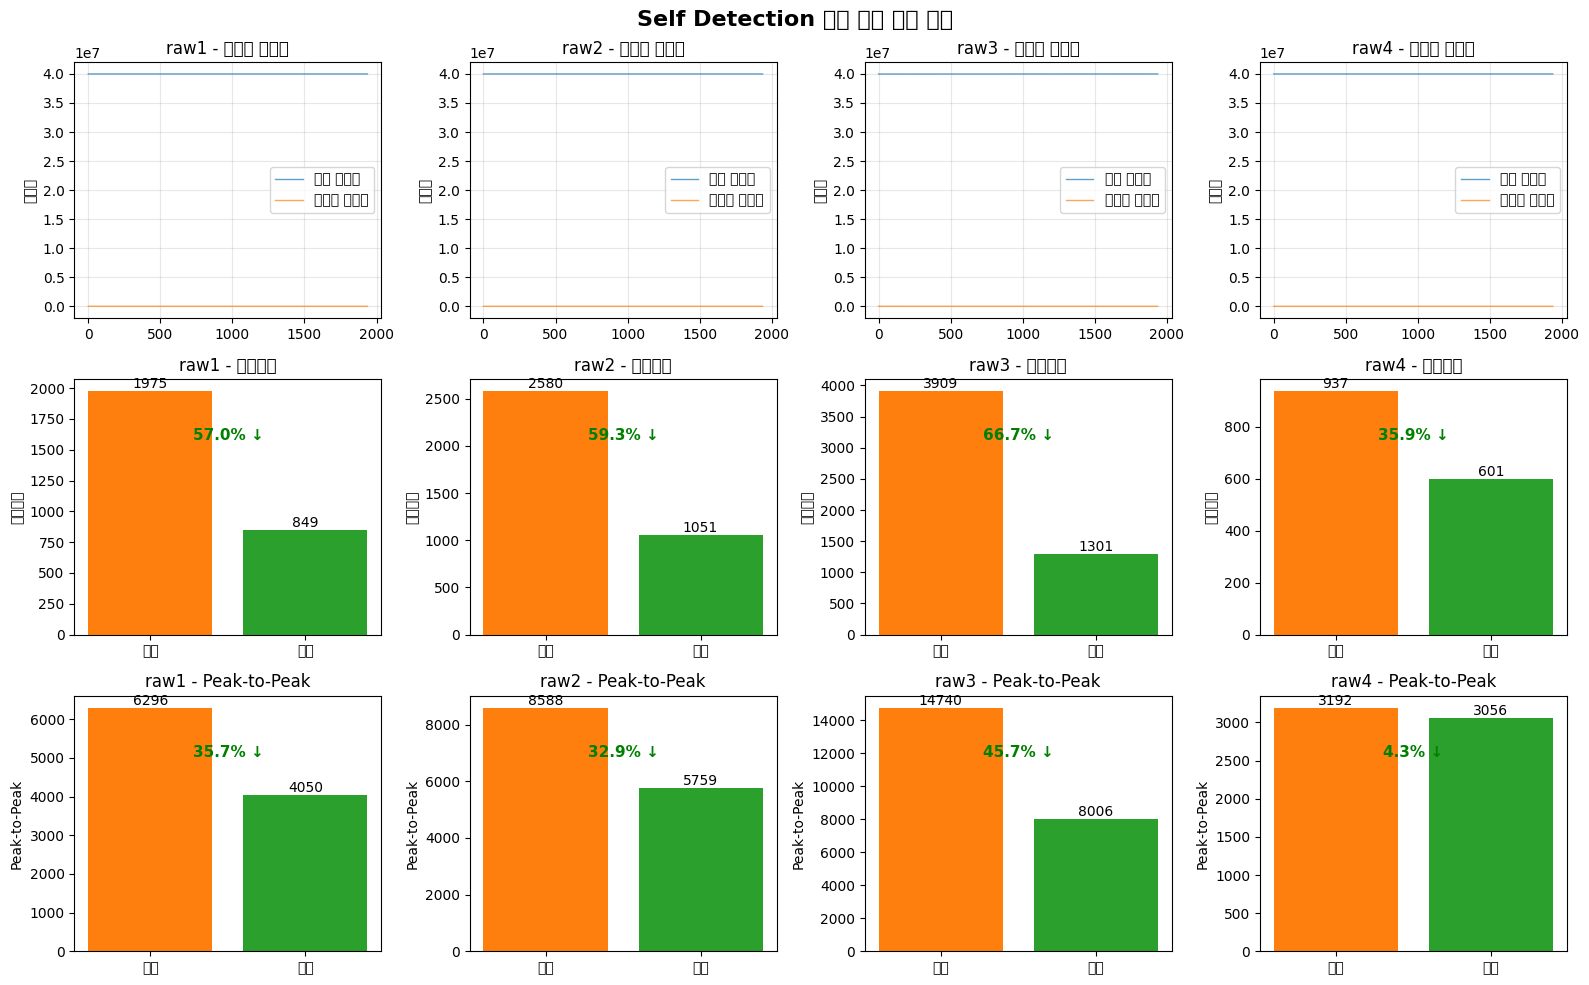


Self Detection 보상 효과 요약

전체 평균 개선율:
  평균 표준편차 감소: 54.7%
  평균 Peak-to-Peak 감소: 29.6%


In [36]:
# Self Detection 효과 시각화
print("\n[11단계] Self Detection 효과 분석...")

# 전체 검증 데이터에 대해 보상 적용
compensated_sensors = y_val_denorm - predictions_denorm

# 각 센서별 통계 계산
channel_names = ['raw1', 'raw2', 'raw3', 'raw4']
results = {}

for i, name in enumerate(channel_names):
    original = y_val_denorm[:, i]
    compensated = compensated_sensors[:, i]
    
    # 표준편차 감소율
    std_original = np.std(original)
    std_compensated = np.std(compensated)
    std_reduction = (std_original - std_compensated) / std_original * 100
    
    # Peak-to-peak 감소율
    ptp_original = np.max(original) - np.min(original)
    ptp_compensated = np.max(compensated) - np.min(compensated)
    ptp_reduction = (ptp_original - ptp_compensated) / ptp_original * 100
    
    results[name] = {
        'std_original': std_original,
        'std_compensated': std_compensated,
        'std_reduction': std_reduction,
        'ptp_original': ptp_original,
        'ptp_compensated': ptp_compensated,
        'ptp_reduction': ptp_reduction,
        'original': original,
        'compensated': compensated
    }
    
    print(f"\n  [{name}]")
    print(f"    표준편차: {std_original:.2f} → {std_compensated:.2f} ({std_reduction:.1f}% 감소)")
    print(f"    Peak-to-Peak: {ptp_original:.2f} → {ptp_compensated:.2f} ({ptp_reduction:.1f}% 감소)")

# 그래프 그리기
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle('Self Detection 센서 보상 효과 분석', fontsize=16, fontweight='bold')

# 1행: 원본 vs 보상된 센서값 시계열
for i, name in enumerate(channel_names):
    ax = axes[0, i]
    original = results[name]['original']
    compensated = results[name]['compensated']
    
    ax.plot(original, label='원본 센서값', alpha=0.7, linewidth=1)
    ax.plot(compensated, label='보상된 센서값', alpha=0.7, linewidth=1)
    ax.set_title(f'{name} - 시계열 데이터')
    ax.set_ylabel('센서값')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 2행: 표준편차 감소율 비교
for i, name in enumerate(channel_names):
    ax = axes[1, i]
    std_original = results[name]['std_original']
    std_compensated = results[name]['std_compensated']
    
    bars = ax.bar(['원본', '보상'], [std_original, std_compensated], color=['#ff7f0e', '#2ca02c'])
    ax.set_title(f'{name} - 표준편차')
    ax.set_ylabel('표준편차')
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom')
    
    # 감소율 표시
    reduction_rate = results[name]['std_reduction']
    ax.text(0.5, max(std_original, std_compensated) * 0.8,
            f'{reduction_rate:.1f}% ↓', ha='center', fontsize=11, fontweight='bold', color='green')

# 3행: Peak-to-Peak 감소율 비교
for i, name in enumerate(channel_names):
    ax = axes[2, i]
    ptp_original = results[name]['ptp_original']
    ptp_compensated = results[name]['ptp_compensated']
    
    bars = ax.bar(['원본', '보상'], [ptp_original, ptp_compensated], color=['#ff7f0e', '#2ca02c'])
    ax.set_title(f'{name} - Peak-to-Peak')
    ax.set_ylabel('Peak-to-Peak')
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom')
    
    # 감소율 표시
    reduction_rate = results[name]['ptp_reduction']
    ax.text(0.5, max(ptp_original, ptp_compensated) * 0.8,
            f'{reduction_rate:.1f}% ↓', ha='center', fontsize=11, fontweight='bold', color='green')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Self Detection 보상 효과 요약")
print("="*60)
print("\n전체 평균 개선율:")
avg_std_reduction = np.mean([results[name]['std_reduction'] for name in channel_names])
avg_ptp_reduction = np.mean([results[name]['ptp_reduction'] for name in channel_names])
print(f"  평균 표준편차 감소: {avg_std_reduction:.1f}%")
print(f"  평균 Peak-to-Peak 감소: {avg_ptp_reduction:.1f}%")


## 12단계: 원본 vs 학습된 센서값 비교


[12단계] 원본 vs 학습된 센서값 비교...


C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:40: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:40: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:40: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:40: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:40: UserWarning: Glyph 49468 (\N{HANGUL SYLLABLE SEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:40: UserWarning: Glyph

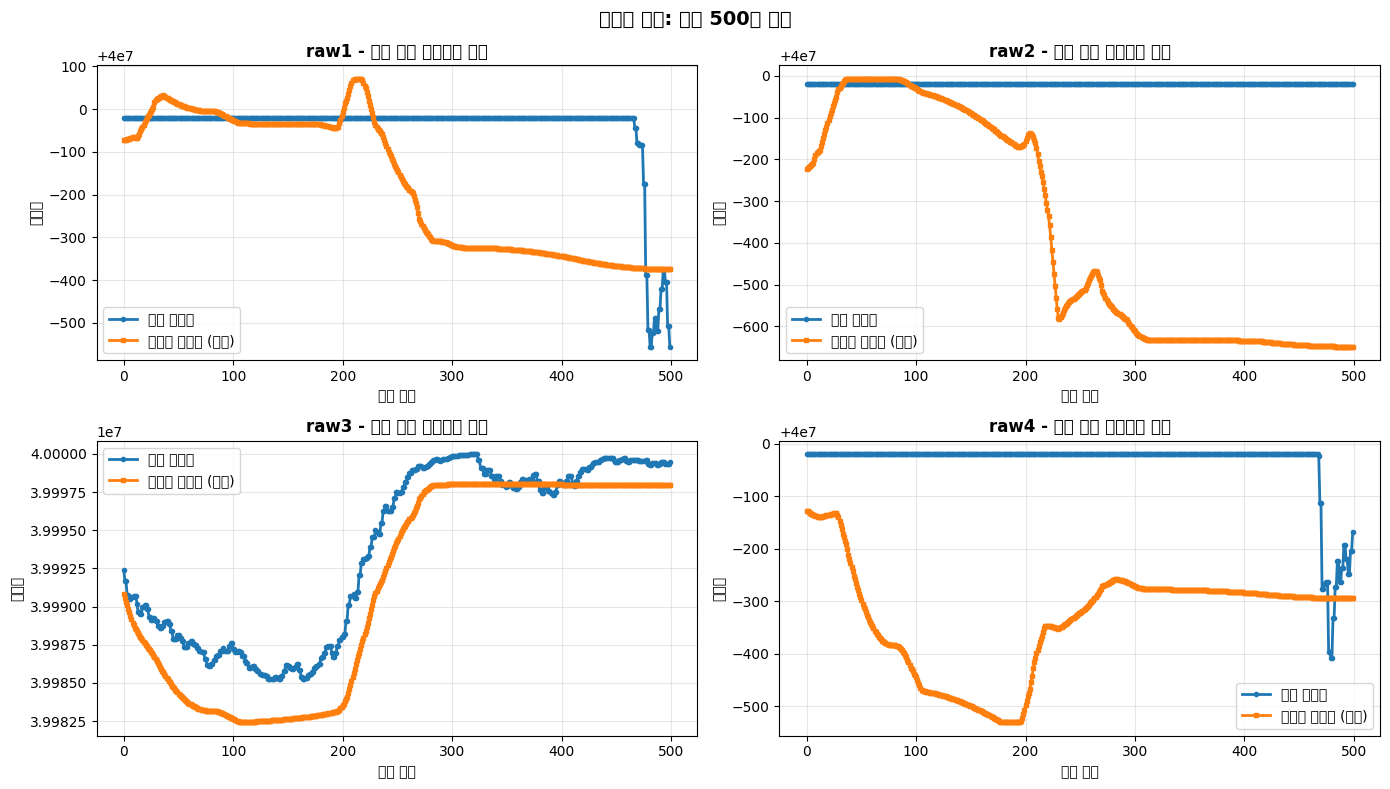


✓ 처음 500개 샘플 플롯 완료


C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:40: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:40: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\SongYoungBin\Desktop\self_detection_mlp\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SongYoungBin\Desktop\self_detection_mlp\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


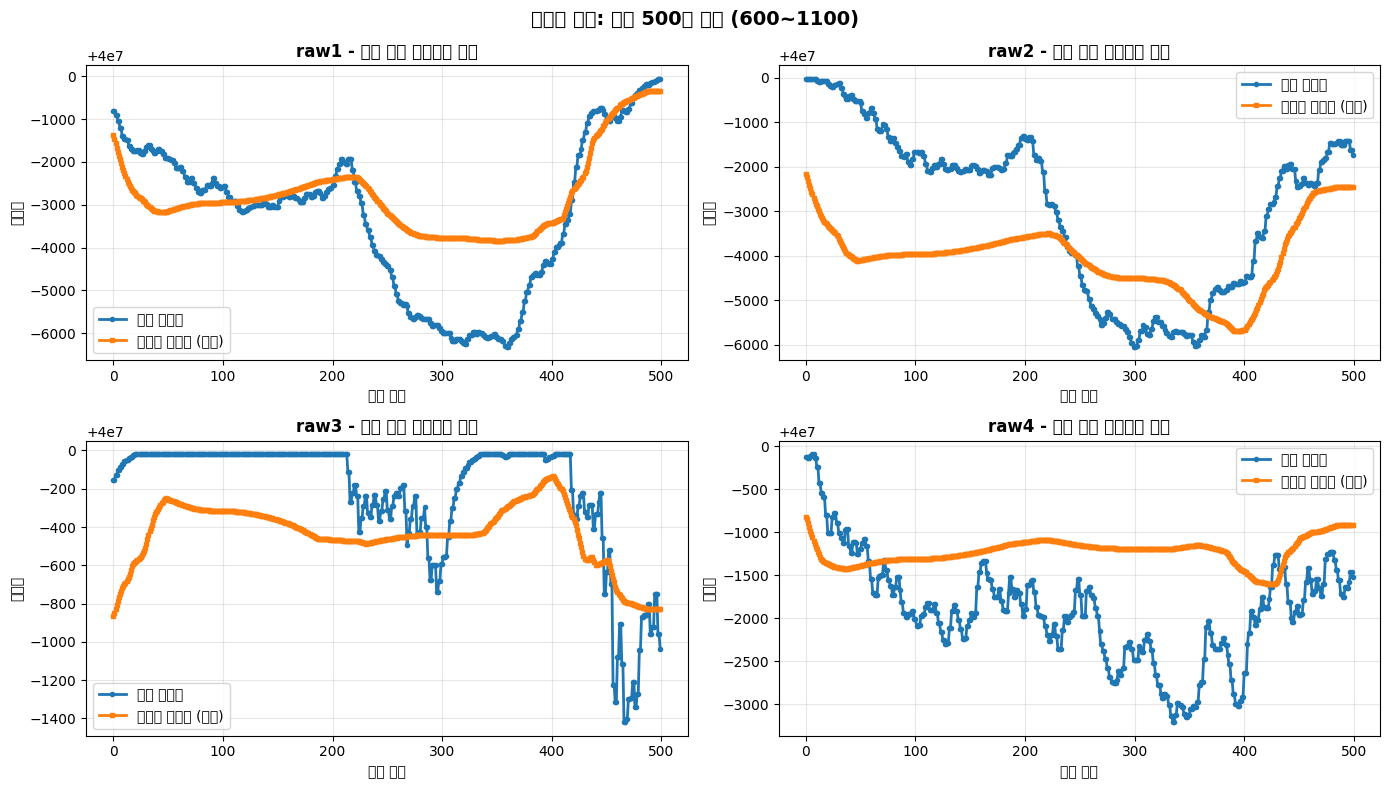


✓ 중간 500개 샘플 (600~1100) 플롯 완료


C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:40: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\SongYoungBin\Desktop\self_detection_mlp\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


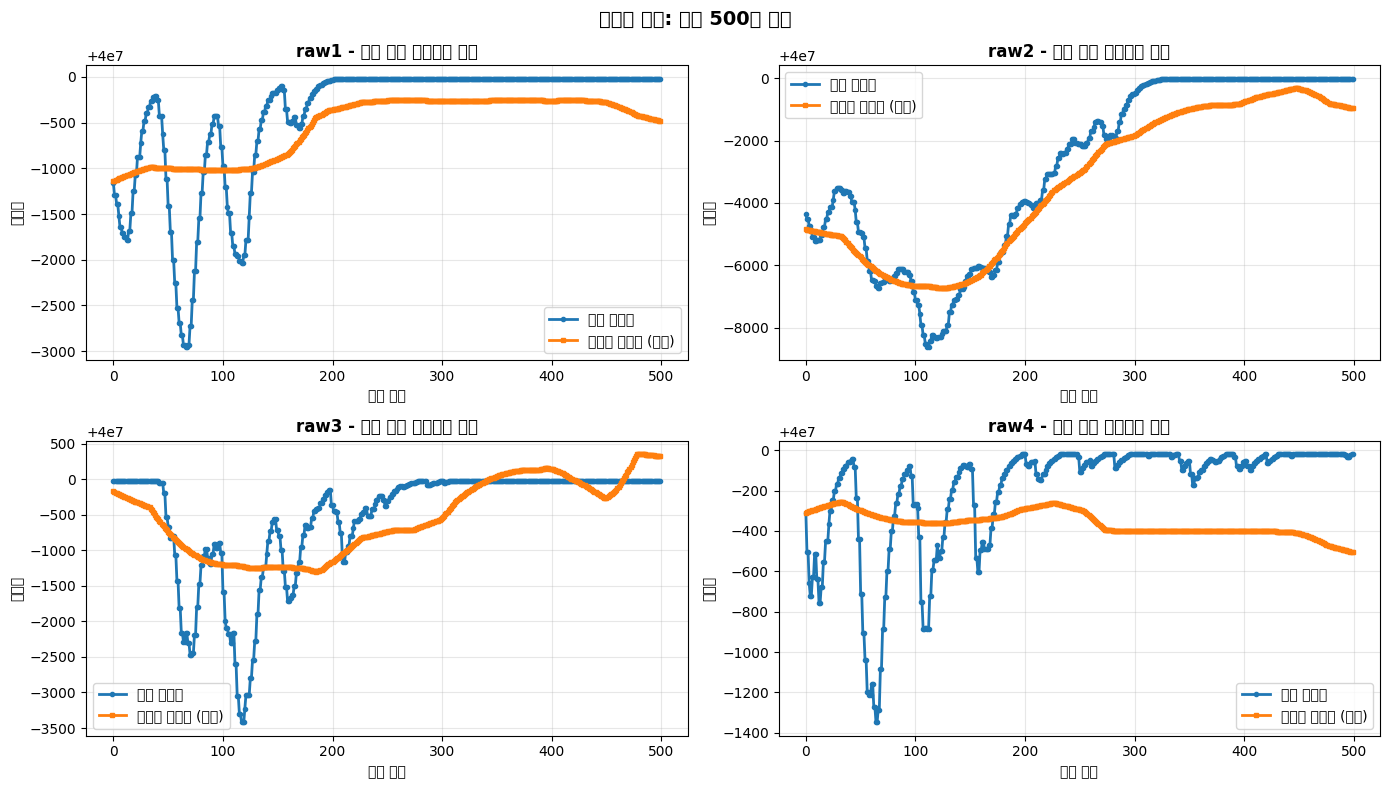

C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph


✓ 나중 500개 샘플 플롯 완료

전체 검증 데이터 개요


C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1803540081.py:83: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\SongYoungBin\Desktop\self_detection_mlp\.venv\lib\site-packages\IPython\core\pylabtool

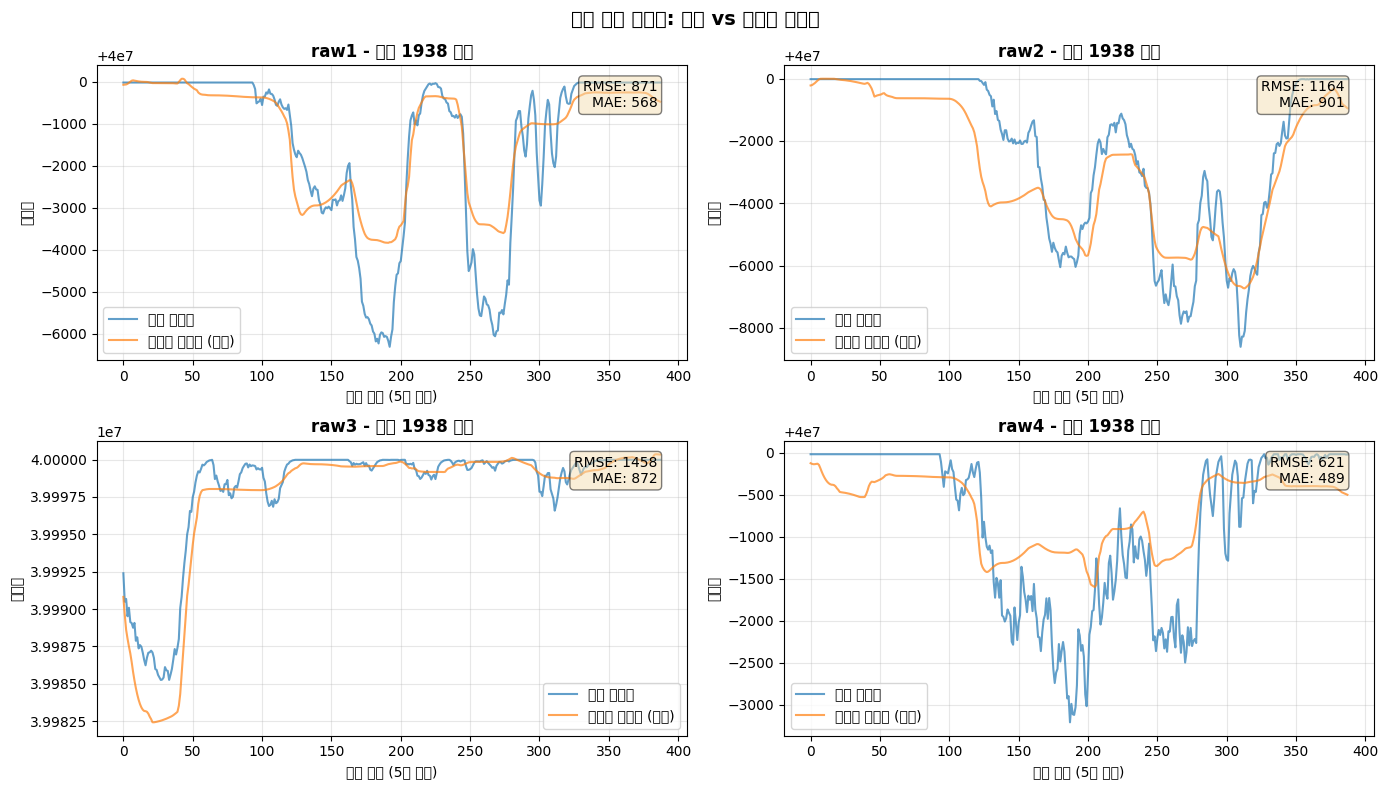


각 센서별 오차 분석

[raw1]
  MSE:  758575.64
  RMSE: 870.96
  MAE:  568.05

[raw2]
  MSE:  1354391.85
  RMSE: 1163.78
  MAE:  901.36

[raw3]
  MSE:  2125735.66
  RMSE: 1457.99
  MAE:  872.14

[raw4]
  MSE:  385322.08
  RMSE: 620.74
  MAE:  489.03


In [37]:
# 원본 vs 학습된 센서값 비교
print("\n[12단계] 원본 vs 학습된 센서값 비교...")

channel_names = ['raw1', 'raw2', 'raw3', 'raw4']

# 2개의 시간 구간 선택 (전체 데이터 일부)
sections = [
    {'name': '처음 500개 샘플', 'start': 0, 'end': 500},
    {'name': '중간 500개 샘플 (600~1100)', 'start': 600, 'end': 1100},
    {'name': '나중 500개 샘플', 'start': -500, 'end': None}
]

for section in sections:
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f'센서값 비교: {section["name"]}', fontsize=14, fontweight='bold')
    
    start_idx = section['start']
    end_idx = section['end']
    
    for i, name in enumerate(channel_names):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        
        # 데이터 슬라이싱
        original_data = y_val_denorm[start_idx:end_idx, i]
        predicted_data = predictions_denorm[start_idx:end_idx, i]
        x_axis = np.arange(len(original_data))
        
        # 원본과 학습된 값 플롯
        ax.plot(x_axis, original_data, label='원본 센서값', linewidth=2, color='#1f77b4', marker='o', markersize=3)
        ax.plot(x_axis, predicted_data, label='학습된 기울기 (예측)', linewidth=2, color='#ff7f0e', marker='s', markersize=3)
        
        ax.set_title(f'{name} - 로봇 자체 움직임의 영향', fontsize=12, fontweight='bold')
        ax.set_xlabel('샘플 번호')
        ax.set_ylabel('센서값')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(f"\n✓ {section['name']} 플롯 완료")

# 전체 데이터 개요 (줌아웃)
print("\n" + "="*60)
print("전체 검증 데이터 개요")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('전체 검증 데이터: 원본 vs 학습된 센서값', fontsize=14, fontweight='bold')

for i, name in enumerate(channel_names):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # 전체 데이터 플롯 (다운샘플링으로 표시)
    original_data = y_val_denorm[:, i]
    predicted_data = predictions_denorm[:, i]
    
    # 매 5번째 샘플만 표시 (가독성)
    step = 5
    x_axis = np.arange(0, len(original_data), step)
    
    ax.plot(original_data[::step], label='원본 센서값', linewidth=1.5, color='#1f77b4', alpha=0.7)
    ax.plot(predicted_data[::step], label='학습된 기울기 (예측)', linewidth=1.5, color='#ff7f0e', alpha=0.7)
    
    ax.set_title(f'{name} - 전체 {len(original_data)} 샘플', fontsize=12, fontweight='bold')
    ax.set_xlabel('샘플 번호 (5개 간격)')
    ax.set_ylabel('센서값')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # 통계 정보 표시
    rmse_value = np.sqrt(np.mean((original_data - predicted_data) ** 2))
    mae_value = np.mean(np.abs(original_data - predicted_data))
    
    stats_text = f'RMSE: {rmse_value:.0f}\nMAE: {mae_value:.0f}'
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# 각 센서별 오차 분석
print("\n" + "="*60)
print("각 센서별 오차 분석")
print("="*60)

for i, name in enumerate(channel_names):
    original = y_val_denorm[:, i]
    predicted = predictions_denorm[:, i]
    
    mse = np.mean((original - predicted) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(original - predicted))
    
    print(f"\n[{name}]")
    print(f"  MSE:  {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")


## 13단계: 센서 보상 과정 상세 분석 (원본 - 학습된 오프셋 = 보상된 값)


[13단계] 센서 보상 과정 상세 분석
공식: 보상된 센서값 = 원본 센서값 - 학습된 오프셋(기울기)


[raw1] 상세 분석:
  원본 센서값:
    평균: 39998522.47, 표준편차: 1974.56
    범위: [39993684.00, 39999980.00]
  학습된 오프셋(Self Detection):
    평균: 39998718.35, 표준편차: 1316.81
    범위: [39996161.61, 40000070.92]
  보상된 센서값 (원본 - 오프셋):
    평균: -195.88, 표준편차: 848.65
    범위: [-2586.00, 1464.40]
  ✓ 표준편차 개선율: 57.0%


C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:90: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:90: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:90: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:90: UserWarning: Glyph 49468 (\N{HANGUL SYLLABLE SEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:90: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:90: UserWarning: Glyph

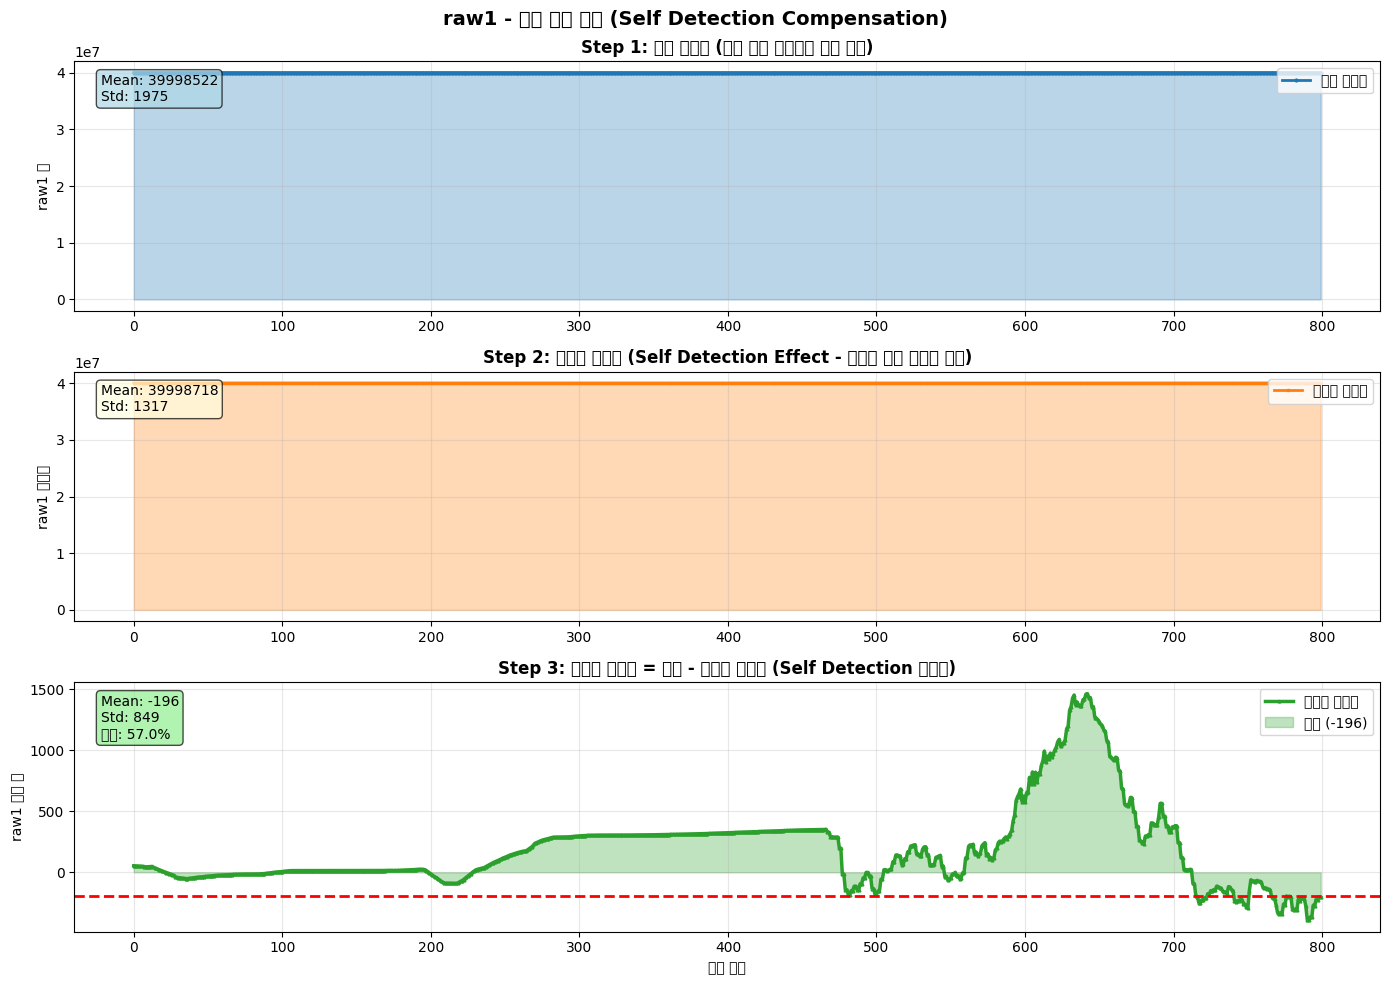



[raw2] 상세 분석:
  원본 센서값:
    평균: 39997673.43, 표준편차: 2580.00
    범위: [39991392.00, 39999980.00]
  학습된 오프셋(Self Detection):
    평균: 39997173.25, 표준편차: 2134.55
    범위: [39993268.36, 39999992.89]
  보상된 센서값 (원본 - 오프셋):
    평균: 500.19, 표준편차: 1050.81
    범위: [-2123.22, 3635.93]
  ✓ 표준편차 개선율: 59.3%


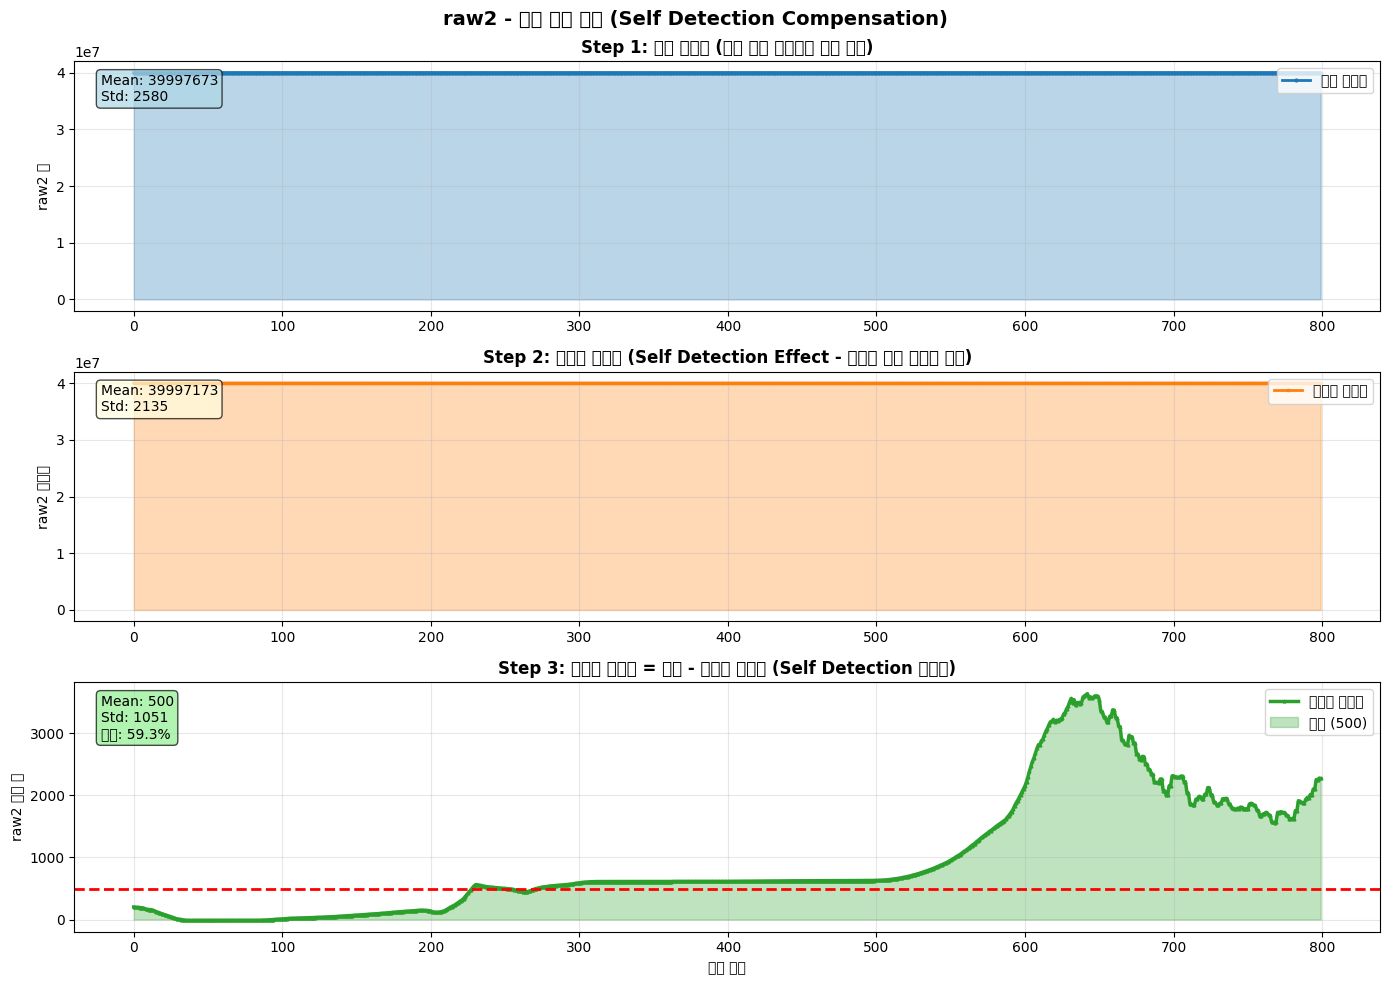



[raw3] 상세 분석:
  원본 센서값:
    평균: 39998039.98, 표준편차: 3908.89
    범위: [39985240.00, 39999980.00]
  학습된 오프셋(Self Detection):
    평균: 39997382.05, 표준편차: 4958.08
    범위: [39982416.02, 40000354.44]
  보상된 센서값 (원본 - 오프셋):
    평균: 657.93, 표준편차: 1301.10
    범위: [-2199.49, 5806.46]
  ✓ 표준편차 개선율: 66.7%


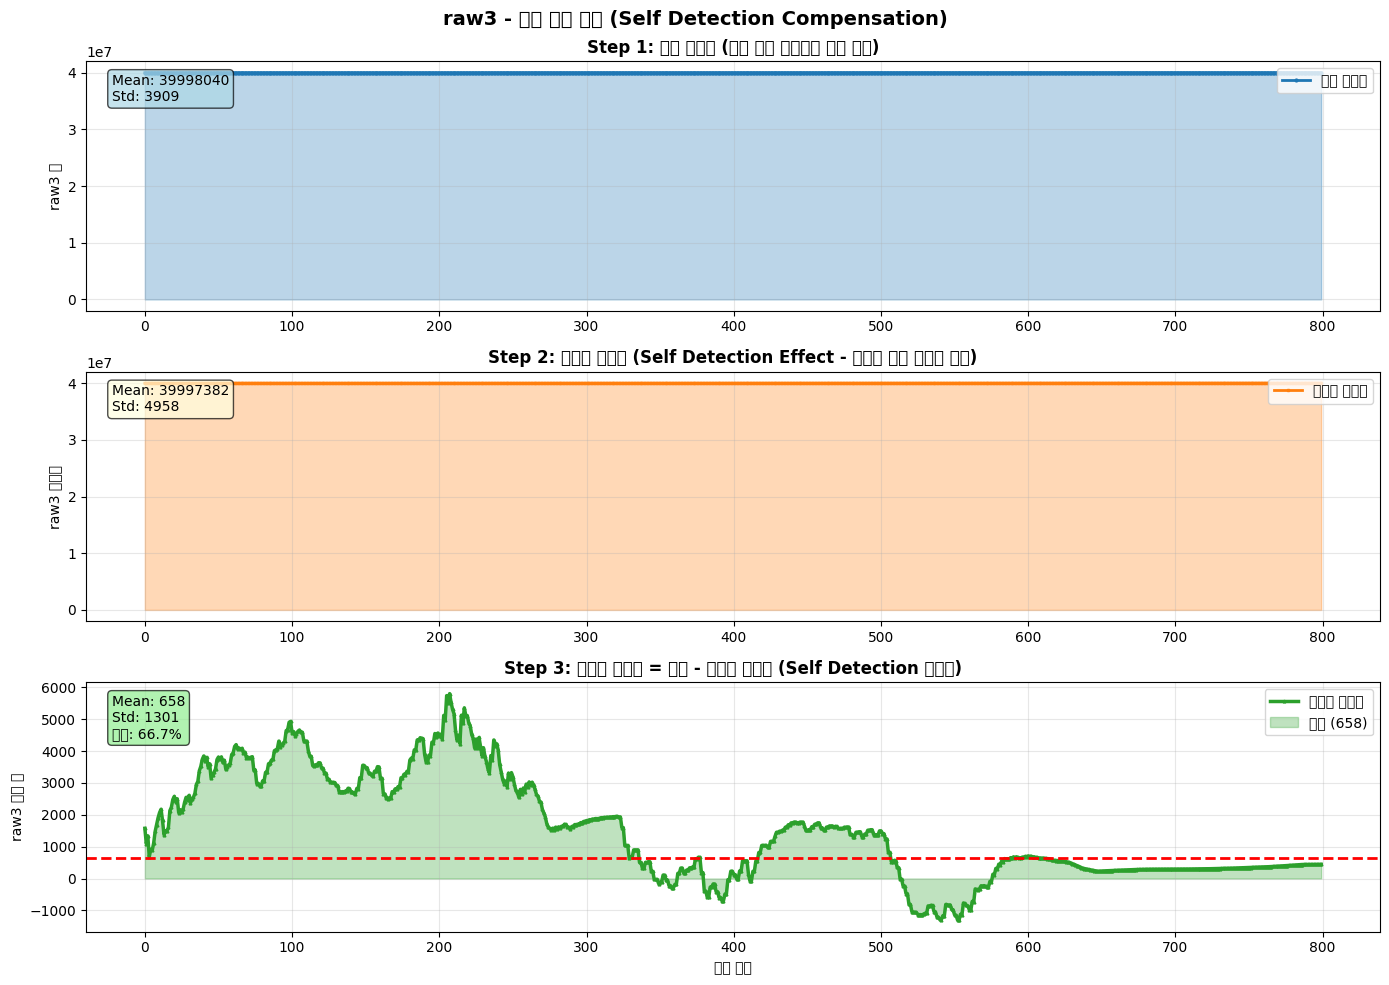



[raw4] 상세 분석:
  원본 센서값:
    평균: 39999156.12, 표준편차: 937.25
    범위: [39996788.00, 39999980.00]
  학습된 오프셋(Self Detection):
    평균: 39999312.98, 표준편차: 420.56
    범위: [39998396.10, 39999872.83]
  보상된 센서값 (원본 - 오프셋):
    평균: -156.87, 표준편차: 600.60
    범위: [-2022.74, 1033.07]
  ✓ 표준편차 개선율: 35.9%


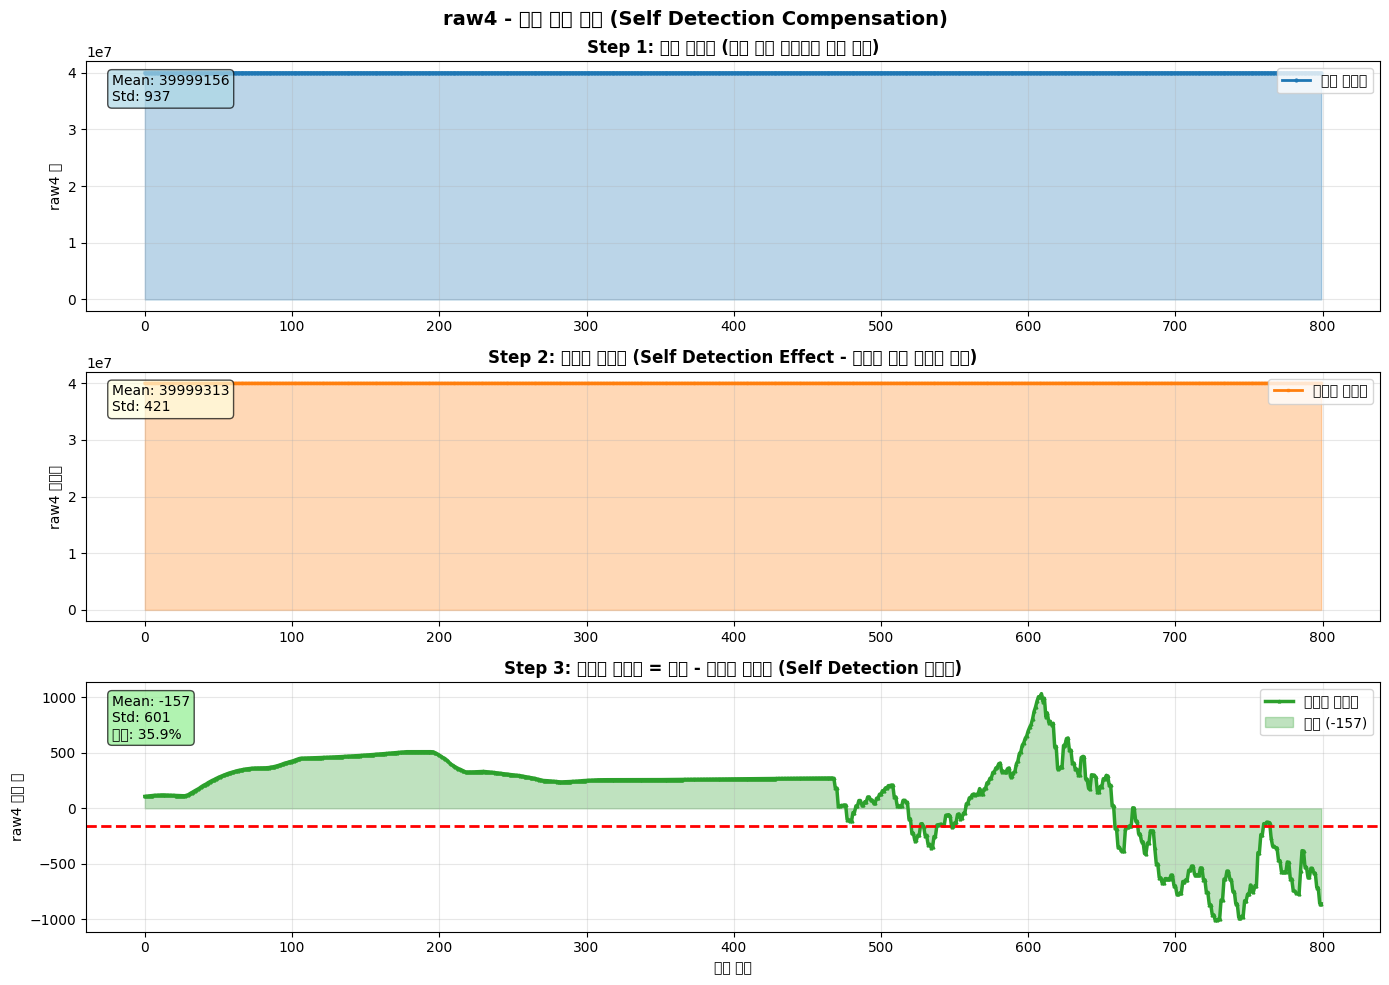



전체 검증 데이터에서의 센서 보상 효과 비교


C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:141: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:141: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:141: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:141: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:141: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SongYoungBin\AppData\Local\Temp\ipykernel_23152\1913343012.py:141: UserWarning: G

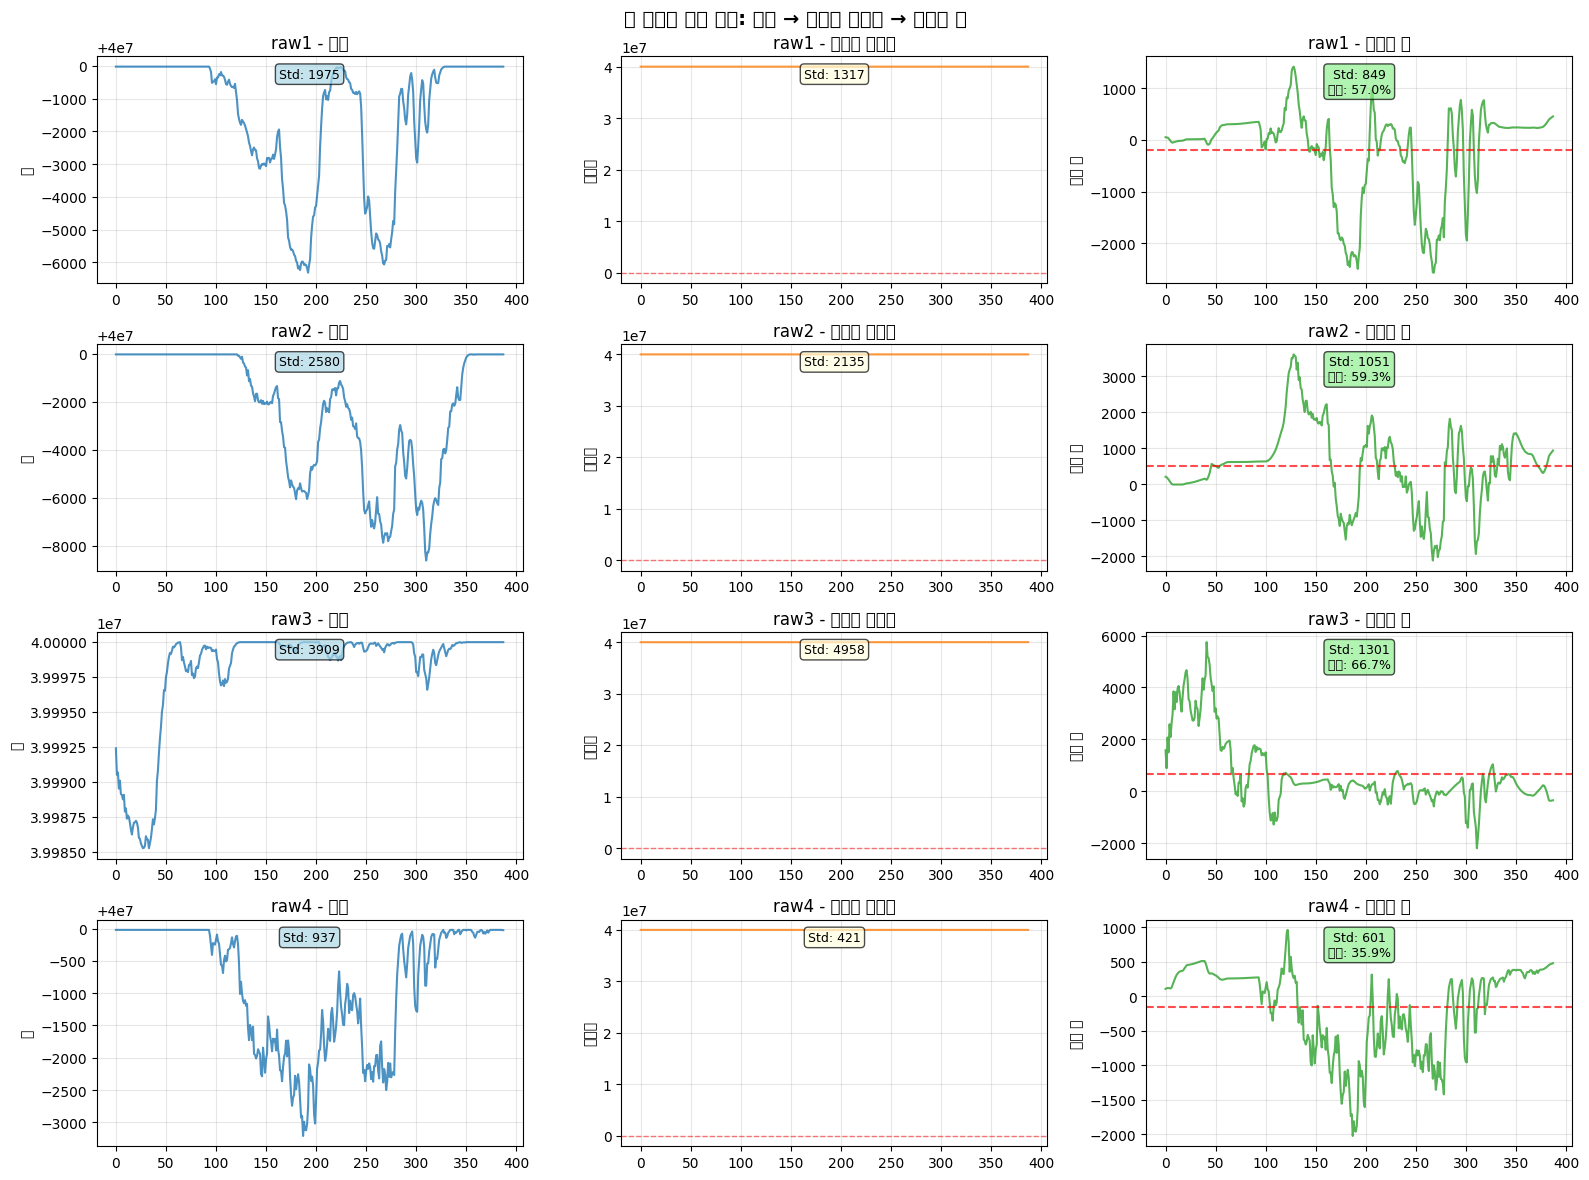


✓ 센서 보상 과정 시각화 완료!


In [38]:
# 센서 보상 과정 상세 분석
print("\n[13단계] 센서 보상 과정 상세 분석")
print("=" * 70)
print("공식: 보상된 센서값 = 원본 센서값 - 학습된 오프셋(기울기)")
print("=" * 70)

channel_names = ['raw1', 'raw2', 'raw3', 'raw4']

# 보상된 센서값 계산
compensated_all = y_val_denorm - predictions_denorm

# 각 센서별 상세 플롯
for sensor_idx, name in enumerate(channel_names):
    print(f"\n\n[{name}] 상세 분석:")
    
    original = y_val_denorm[:, sensor_idx]
    learned_offset = predictions_denorm[:, sensor_idx]
    compensated = compensated_all[:, sensor_idx]
    
    # 통계 정보
    print(f"  원본 센서값:")
    print(f"    평균: {np.mean(original):.2f}, 표준편차: {np.std(original):.2f}")
    print(f"    범위: [{np.min(original):.2f}, {np.max(original):.2f}]")
    
    print(f"  학습된 오프셋(Self Detection):")
    print(f"    평균: {np.mean(learned_offset):.2f}, 표준편차: {np.std(learned_offset):.2f}")
    print(f"    범위: [{np.min(learned_offset):.2f}, {np.max(learned_offset):.2f}]")
    
    print(f"  보상된 센서값 (원본 - 오프셋):")
    print(f"    평균: {np.mean(compensated):.2f}, 표준편차: {np.std(compensated):.2f}")
    print(f"    범위: [{np.min(compensated):.2f}, {np.max(compensated):.2f}]")
    
    improvement = (np.std(original) - np.std(compensated)) / np.std(original) * 100
    print(f"  ✓ 표준편차 개선율: {improvement:.1f}%")
    
    # 3행 플롯: 처음 800개 샘플
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    fig.suptitle(f'{name} - 센서 보상 과정 (Self Detection Compensation)', 
                 fontsize=14, fontweight='bold')
    
    sample_range = 800
    x_axis = np.arange(sample_range)
    
    # 1행: 원본 센서값
    ax = axes[0]
    ax.plot(x_axis, original[:sample_range], linewidth=2, color='#1f77b4', marker='o', markersize=2)
    ax.fill_between(x_axis, original[:sample_range], alpha=0.3, color='#1f77b4')
    ax.set_title(f'Step 1: 원본 센서값 (로봇 자체 움직임의 영향 포함)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{name} 값')
    ax.grid(True, alpha=0.3)
    ax.legend(['원본 센서값'], loc='upper right')
    
    # 통계 표시
    stats_text = f'Mean: {np.mean(original):.0f}\nStd: {np.std(original):.0f}'
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # 2행: 학습된 오프셋
    ax = axes[1]
    ax.plot(x_axis, learned_offset[:sample_range], linewidth=2, color='#ff7f0e', marker='s', markersize=2)
    ax.fill_between(x_axis, learned_offset[:sample_range], alpha=0.3, color='#ff7f0e')
    ax.set_title(f'Step 2: 학습된 오프셋 (Self Detection Effect - 로봇의 자체 움직임 영향)', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{name} 오프셋')
    ax.grid(True, alpha=0.3)
    ax.legend(['학습된 오프셋'], loc='upper right')
    
    # 통계 표시
    stats_text = f'Mean: {np.mean(learned_offset):.0f}\nStd: {np.std(learned_offset):.0f}'
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    
    # 3행: 보상된 센서값
    ax = axes[2]
    ax.plot(x_axis, compensated[:sample_range], linewidth=2.5, color='#2ca02c', marker='^', markersize=2)
    ax.fill_between(x_axis, compensated[:sample_range], alpha=0.3, color='#2ca02c')
    ax.axhline(y=np.mean(compensated), color='red', linestyle='--', linewidth=2, label='평균값')
    ax.set_title(f'Step 3: 보상된 센서값 = 원본 - 학습된 오프셋 (Self Detection 제거됨)', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{name} 보상 값')
    ax.set_xlabel('샘플 번호')
    ax.grid(True, alpha=0.3)
    ax.legend(['보상된 센서값', f'평균 ({np.mean(compensated):.0f})'], loc='upper right')
    
    # 통계 표시
    stats_text = f'Mean: {np.mean(compensated):.0f}\nStd: {np.std(compensated):.0f}\n개선: {improvement:.1f}%'
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# 전체 센서 비교 (전체 샘플)
print("\n\n" + "="*70)
print("전체 검증 데이터에서의 센서 보상 효과 비교")
print("="*70)

fig, axes = plt.subplots(4, 3, figsize=(16, 12))
fig.suptitle('각 센서별 보상 과정: 원본 → 학습된 오프셋 → 보상된 값', 
             fontsize=14, fontweight='bold')

for sensor_idx, name in enumerate(channel_names):
    original = y_val_denorm[:, sensor_idx]
    learned_offset = predictions_denorm[:, sensor_idx]
    compensated = compensated_all[:, sensor_idx]
    
    # 1열: 원본 센서값
    ax = axes[sensor_idx, 0]
    ax.plot(original[::5], linewidth=1.5, color='#1f77b4', alpha=0.8)
    ax.set_title(f'{name} - 원본')
    ax.set_ylabel('값')
    ax.grid(True, alpha=0.3)
    ax.text(0.5, 0.95, f'Std: {np.std(original):.0f}', transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # 2열: 학습된 오프셋
    ax = axes[sensor_idx, 1]
    ax.plot(learned_offset[::5], linewidth=1.5, color='#ff7f0e', alpha=0.8)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_title(f'{name} - 학습된 오프셋')
    ax.set_ylabel('오프셋')
    ax.grid(True, alpha=0.3)
    ax.text(0.5, 0.95, f'Std: {np.std(learned_offset):.0f}', transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    
    # 3열: 보상된 값
    ax = axes[sensor_idx, 2]
    ax.plot(compensated[::5], linewidth=1.5, color='#2ca02c', alpha=0.8)
    ax.axhline(y=np.mean(compensated), color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_title(f'{name} - 보상된 값')
    ax.set_ylabel('보상 값')
    ax.grid(True, alpha=0.3)
    
    improvement = (np.std(original) - np.std(compensated)) / np.std(original) * 100
    ax.text(0.5, 0.95, f'Std: {np.std(compensated):.0f}\n개선: {improvement:.1f}%', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n✓ 센서 보상 과정 시각화 완료!")


## 13-추가단계: Residual Short-Memory 모델 (히스테리시스/완화 성분 보정)

정적 MLP(offset-only)로 baseline을 제거한 뒤에도 **구조적인 패턴**이 남으면, baseline이 **과거 이력(history)**에 의존할 가능성이 큽니다.

- Stage-1: \(\hat b(t)=f(q(t),\dot q(t))\)
- Residual: \(r(t)=y(t)-\hat b(t)\)
- Stage-2: \(\hat r(t)=g([r(t-1),...,r(t-K)])\)
- Final: \(y_{corr}(t)=y(t)-\hat b(t)-\hat r(t)\)

아래에서는 **짧은 윈도우(K)**의 잔차만 입력으로 사용하는 작은 MLP를 학습합니다.


In [ ]:
# 모델 저장 및 최종 결과 정리
print("\n[13단계] 모델 저장 및 최종 결과 정리")
print("="*70)

import json
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

# ================================================
# Stage 1 및 Stage 2 모델 저장
# ================================================
print("\n[모델 저장]")

# Stage 1 저장
stage1_path = os.path.join(results_dir, f"stage1_model_{timestamp}.pt")
stage1_config = {
    'input_dim': 5,      # q2-q6 only
    'output_dim': 4,     # 4 센서
    'hidden_dim': 32,
    'architecture': 'SelfDetectionMLP'
}
torch.save({
    'model_state': model.state_dict(),
    'config': stage1_config,
    'normalization': {
        'means': normalizer.means.tolist(),
        'stds': normalizer.stds.tolist()
    }
}, stage1_path)
print(f"  ✓ Stage 1 모델 저장: {stage1_path}")

# Stage 2 저장
stage2_path = os.path.join(results_dir, f"stage2_model_{timestamp}.pt")
stage2_config = {
    'memory_window': MEMORY_WINDOW,  # K=5
    'output_dim': 4,
    'hidden_dim': STAGE2_HIDDEN_DIM,  # 12
    'architecture': 'Stage2ResidualMemoryMLP'
}
torch.save({
    'model_state': stage2_model.state_dict(),
    'config': stage2_config,
    'normalization': {
        'residual_train_mean': residual_train_mean.tolist(),
        'residual_train_std': residual_train_std.tolist(),
        'target_train_mean': target_train_mean.tolist(),
        'target_train_std': target_train_std.tolist()
    }
}, stage2_path)
print(f"  ✓ Stage 2 모델 저장: {stage2_path}")

# ================================================
# 두 단계의 최종 성능 비교
# ================================================
print("\n[최종 성능 비교]")
print("-" * 70)

# Stage 2 검증 예측
stage2_model.eval()
with torch.no_grad():
    stage2_val_seqs = torch.from_numpy(residual_seqs_val_norm).float().to(device)
    stage2_pred_val_norm = stage2_model(stage2_val_seqs).cpu().numpy()

# Denormalize Stage 2 예측
stage2_pred_val = stage2_pred_val_norm * target_train_std + target_train_mean

# Stage 2 corrected (Stage 1 잔차 - Stage 2 예측)
# Stage 2 출력은 residual_seqs_val[MEMORY_WINDOW:] 과 매칭
stage2_corrected = np.full_like(residual)
stage2_corrected[:MEMORY_WINDOW] = np.nan  # 초기 메모리 부족
stage2_corrected[MEMORY_WINDOW:] = residual[MEMORY_WINDOW:] - stage2_pred_val

print("\n센서별 보정 성능:")
print("-" * 70)
print(f"{'센서':>8} {'원본':>12} {'Stage1':>12} {'Stage1+2':>12} {'개선':>10}")
print("-" * 70)

improvements = []
for i, sensor_name in enumerate(['raw1', 'raw2', 'raw3', 'raw4']):
    # 원본 신호 표준편차
    original_std = np.std(y_val_original[:, i])
    
    # Stage 1 후 잔차
    stage1_std = np.std(residual[:, i])
    
    # Stage 2 후 잔차 (유효한 부분만)
    valid_mask = ~np.isnan(stage2_corrected[:, i])
    stage2_std = np.std(stage2_corrected[valid_mask, i]) if valid_mask.sum() > 0 else np.nan
    
    # 개선율 (원본 대비)
    improvement = (1 - stage2_std / original_std) * 100 if not np.isnan(stage2_std) else np.nan
    improvements.append(improvement)
    
    print(f"{sensor_name:>8} {original_std:>12.4f} {stage1_std:>12.4f} {stage2_std:>12.4f} {improvement:>9.1f}%")

print("-" * 70)
avg_improvement = np.nanmean(improvements)
print(f"{'평균':>8} {'-':>12} {'-':>12} {'-':>12} {avg_improvement:>9.1f}%")
print("="*70)

print("\n✓ 두 단계 자기 검출 보정 완료!")
print(f"  - Stage 1: 자세 의존적 기선 오프셋 제거")
print(f"  - Stage 2: 히스테리시스/유전체 완화 효과 제거")
print(f"  - 평균 개선율: {avg_improvement:.1f}%")


## 14단계: 결과 데이터 파일 저장

In [17]:
# 결과 데이터 파일 저장
print("\n[14단계] 학습 결과 및 보상 데이터 저장 중...")

import os
from datetime import datetime

# 결과 저장 디렉토리 생성
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# 타임스탬프 추가 (같은 이름의 파일 덮어쓰기 방지)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

channel_names = ['raw1', 'raw2', 'raw3', 'raw4']

# ------------------------------------------------------------------
# 1) 전체 검증 결과 저장 (Stage-1, Stage-1+2)
# ------------------------------------------------------------------
print("\n[1] 전체 검증 결과 저장...")

results_data = {
    'sample_idx': np.arange(len(y_val_denorm)),
}

# Stage-1 baseline 예측 (val)
baseline_val = predictions_denorm  # (N,4) = f(q,dq) 역표준화 결과

# Stage-1 corrected
stage1_corr = y_val_denorm - baseline_val

# Stage-2 corrected (있으면 사용)
has_stage2 = 'ycorr_stage2_val' in globals() and ycorr_stage2_val is not None

if has_stage2:
    stage2_corr = ycorr_stage2_val  # already aligned with NaN padding
    # residual prediction aligned (NaN padding) if available
    res_pred_aligned = globals().get('res_pred_val_aligned', None)

# 각 센서별 데이터 저장
for i, name in enumerate(channel_names):
    results_data[f'{name}_original'] = y_val_denorm[:, i]
    results_data[f'{name}_baseline_hat_stage1'] = baseline_val[:, i]
    results_data[f'{name}_ycorr_stage1'] = stage1_corr[:, i]

    if has_stage2:
        results_data[f'{name}_ycorr_stage1plus2'] = stage2_corr[:, i]
        if res_pred_aligned is not None:
            results_data[f'{name}_residual_hat_stage2'] = res_pred_aligned[:, i]

# pandas DataFrame으로 변환
results_df = pd.DataFrame(results_data)

# 파일 저장
results_file = f"{results_dir}/validation_results_with_residual_{timestamp}.csv"
results_df.to_csv(results_file, index=False)
print(f"  ✓ 저장 완료: {results_file}")
print(f"    - 데이터 행 수: {len(results_df)}")
print(f"    - 컬럼 수: {len(results_df.columns)}")

# ------------------------------------------------------------------
# 2) 정규화 통계 저장 (Stage-1 y 정규화 + Stage-2 residual 정규화)
# ------------------------------------------------------------------
print("\n[2] 정규화 파라미터 저장...")

norm_file = f"{results_dir}/normalization_params_{timestamp}.csv"

# Stage-1 normalizer (raw)
stage1_means = normalizer.means
stage1_stds = normalizer.stds

# Stage-2 normalizer (residual) - 있을 경우만
if has_stage2:
    stage2_means = res_mu
    stage2_stds = res_std
else:
    stage2_means = [np.nan]*4
    stage2_stds = [np.nan]*4

norm_df = pd.DataFrame({
    'channel': channel_names,
    'stage1_mean': stage1_means,
    'stage1_std': stage1_stds,
    'stage2_residual_mean': stage2_means,
    'stage2_residual_std': stage2_stds,
})

# window length 기록
norm_df['residual_window_K'] = K if has_stage2 else np.nan

norm_df.to_csv(norm_file, index=False)
print(f"  ✓ 저장 완료: {norm_file}")

# ------------------------------------------------------------------
# 3) 모델 저장
# ------------------------------------------------------------------
print("\n[3] 모델 저장...")

os.makedirs("models", exist_ok=True)

# Stage-1 model
stage1_model_path = f"models/self_detection_model_stage1_{timestamp}.pth"
torch.save(model.state_dict(), stage1_model_path)
print(f"  ✓ Stage-1 model 저장: {stage1_model_path}")

# Stage-2 model (있으면)
if has_stage2:
    stage2_model_path = f"models/self_detection_model_stage2_residual_{timestamp}.pth"
    torch.save(res_model.state_dict(), stage2_model_path)
    print(f"  ✓ Stage-2 residual model 저장: {stage2_model_path}")

print("\n[완료] 결과/모델/정규화 파라미터 저장이 완료되었습니다.")



[14단계] 학습 결과 및 보상 데이터 저장 중...

[1] 전체 검증 결과 저장...
  ✓ 저장 완료: results/validation_results_20260117_154147.csv
    - 데이터 행 수: 1938
    - 컬럼 수: 13

[2] 입력 데이터(관절 각도 및 속도) 저장...
  ✓ 저장 완료: results/input_data_20260117_154147.csv
    - 관절 각도 5개 (j2~j6)
    - 관절 속도 5개 (dj2~dj6)

[3] 센서별 통계 정보 저장...
  ✓ 저장 완료: results/sensor_statistics_20260117_154147.csv

  [센서별 통계 요약]
sensor  original_mean  original_std  original_min  original_max  original_ptp  predicted_mean  predicted_std  predicted_min  predicted_max  compensated_mean  compensated_std  compensated_min  compensated_max  compensated_ptp  std_reduction_percent  ptp_reduction_percent          mse        rmse        mae
  raw1   3.999852e+07   1974.559197    39993684.0    39999980.0        6296.0    3.999868e+07    1339.279846   3.999590e+07   4.000008e+07       -155.336047       866.880758     -2647.738929      1358.371529      4006.110458              56.097505              36.370545 7.756115e+05  880.688104 580.115845
  raw2   3.999767e+07